# Machine Learning to explain the price of electricity

## Authors
- [Paul Zamanian](https://www.linkedin.com/in/paul-zamanian-abbassi-899126196)
- [Matthieu Vichet](https://www.linkedin.com/in/matthieu-vichet-4b31201a8)
- [Benjamin Rossignol](https://www.linkedin.com/in/benjamin-rossignol-4b92521b8)

## Summary

<span style="color:red">INSERT SUMMARY</span>

## Introduction
As of 2023, and since 10 years, the energy didn't stop from rising. In France, the soaring cost of electricity is a real problem for the population. The price of electricity is a complex subject, and it is difficult to understand the reasons for this increase. In this project, we will try to explain the price of electricity in France and Germany, and to predict the price of electricity in the future. So, we will try to answer the following questions:
- Can we fully explain the price of electricity?
- If so, what are the main factors that influence the price of electricity?
- What will be the price of electricity in the next few years?

We will write all the steps inside this notebook. We will use Python, and the libraries that we will use are Pandas, Matplotlib, Scikit-Learn.
#
# Data Description

Here, we have 3 datasets:
#
### Data_X

The first table corresponds the prices of many commodities in France and Germany on a daily basis of approximately 1 000 days. It contains 35 columns, mainly:
- An ID
- The day number
- The country name
- **x_CONSUMPTION**: The energy consumption per country
- **x_y_EXCHANGE**: The energy exchange, how much energy is exchanged between FR and DE
- **x_NET_IMPORT/EXPORT**: The energy import/export
- **x_GAS/COAL/HYDRO/NUCLEAR/SOLAR/WINDPOW**: The energy production per country (mainly gas, coal, hydro, nuclear, solar, wind)
- **DE_LIGNITE**: The lignite production for Germany
- **x_RESIDUAL_LOAD**: The electricity consumption after using all renewable energies
- **x_RAIN/WIND/TEMP**: The weather data
- **GAS_RET/COAL_RET/CARBON_RET**: The gas, coal and carbon prices

There are a lot of variables, so focusing on the most important ones will be a good idea. But, what are the most important ones? Perhaps some of them are correlated, so this is what we will have to study.

#
### Data_Y

This data represents the electricity price data. In fact, we have all the IDs from Data_X and the price of electricity is linked to each ID. So, we will have to train our model on the Data_X dataset, and then predict the price of electricity on the Data_Y dataset.
#

### DataNew_X

This data is similar to Data_X, but it is for different days. This is the dataset that we will try to predict. This is the **TESTING** data.
#

# Data Preparation

Ouv very first step will me to understand the data, and prepare it to be used by our models. We will have to deal with empty cells, categories, and normalize the data. We will also have to select the most important variables, and to study the correlation between them. First, let us import the libraries that we will use:

In [555]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Now that we have imported the libraries, let us import the data:

In [556]:
# Creating the two datasets
data_x: pd.DataFrame = pd.read_csv('data/Data_X.csv')
data_y: pd.DataFrame = pd.read_csv('data/Data_Y.csv')

Now that we have imported the data, we have access to it. Let us see what it looks like. For each variable, we can see the type of the variable, the mean, the standard deviation, the minimum, the maximum, and the quartiles.

(0.0, 1.5)

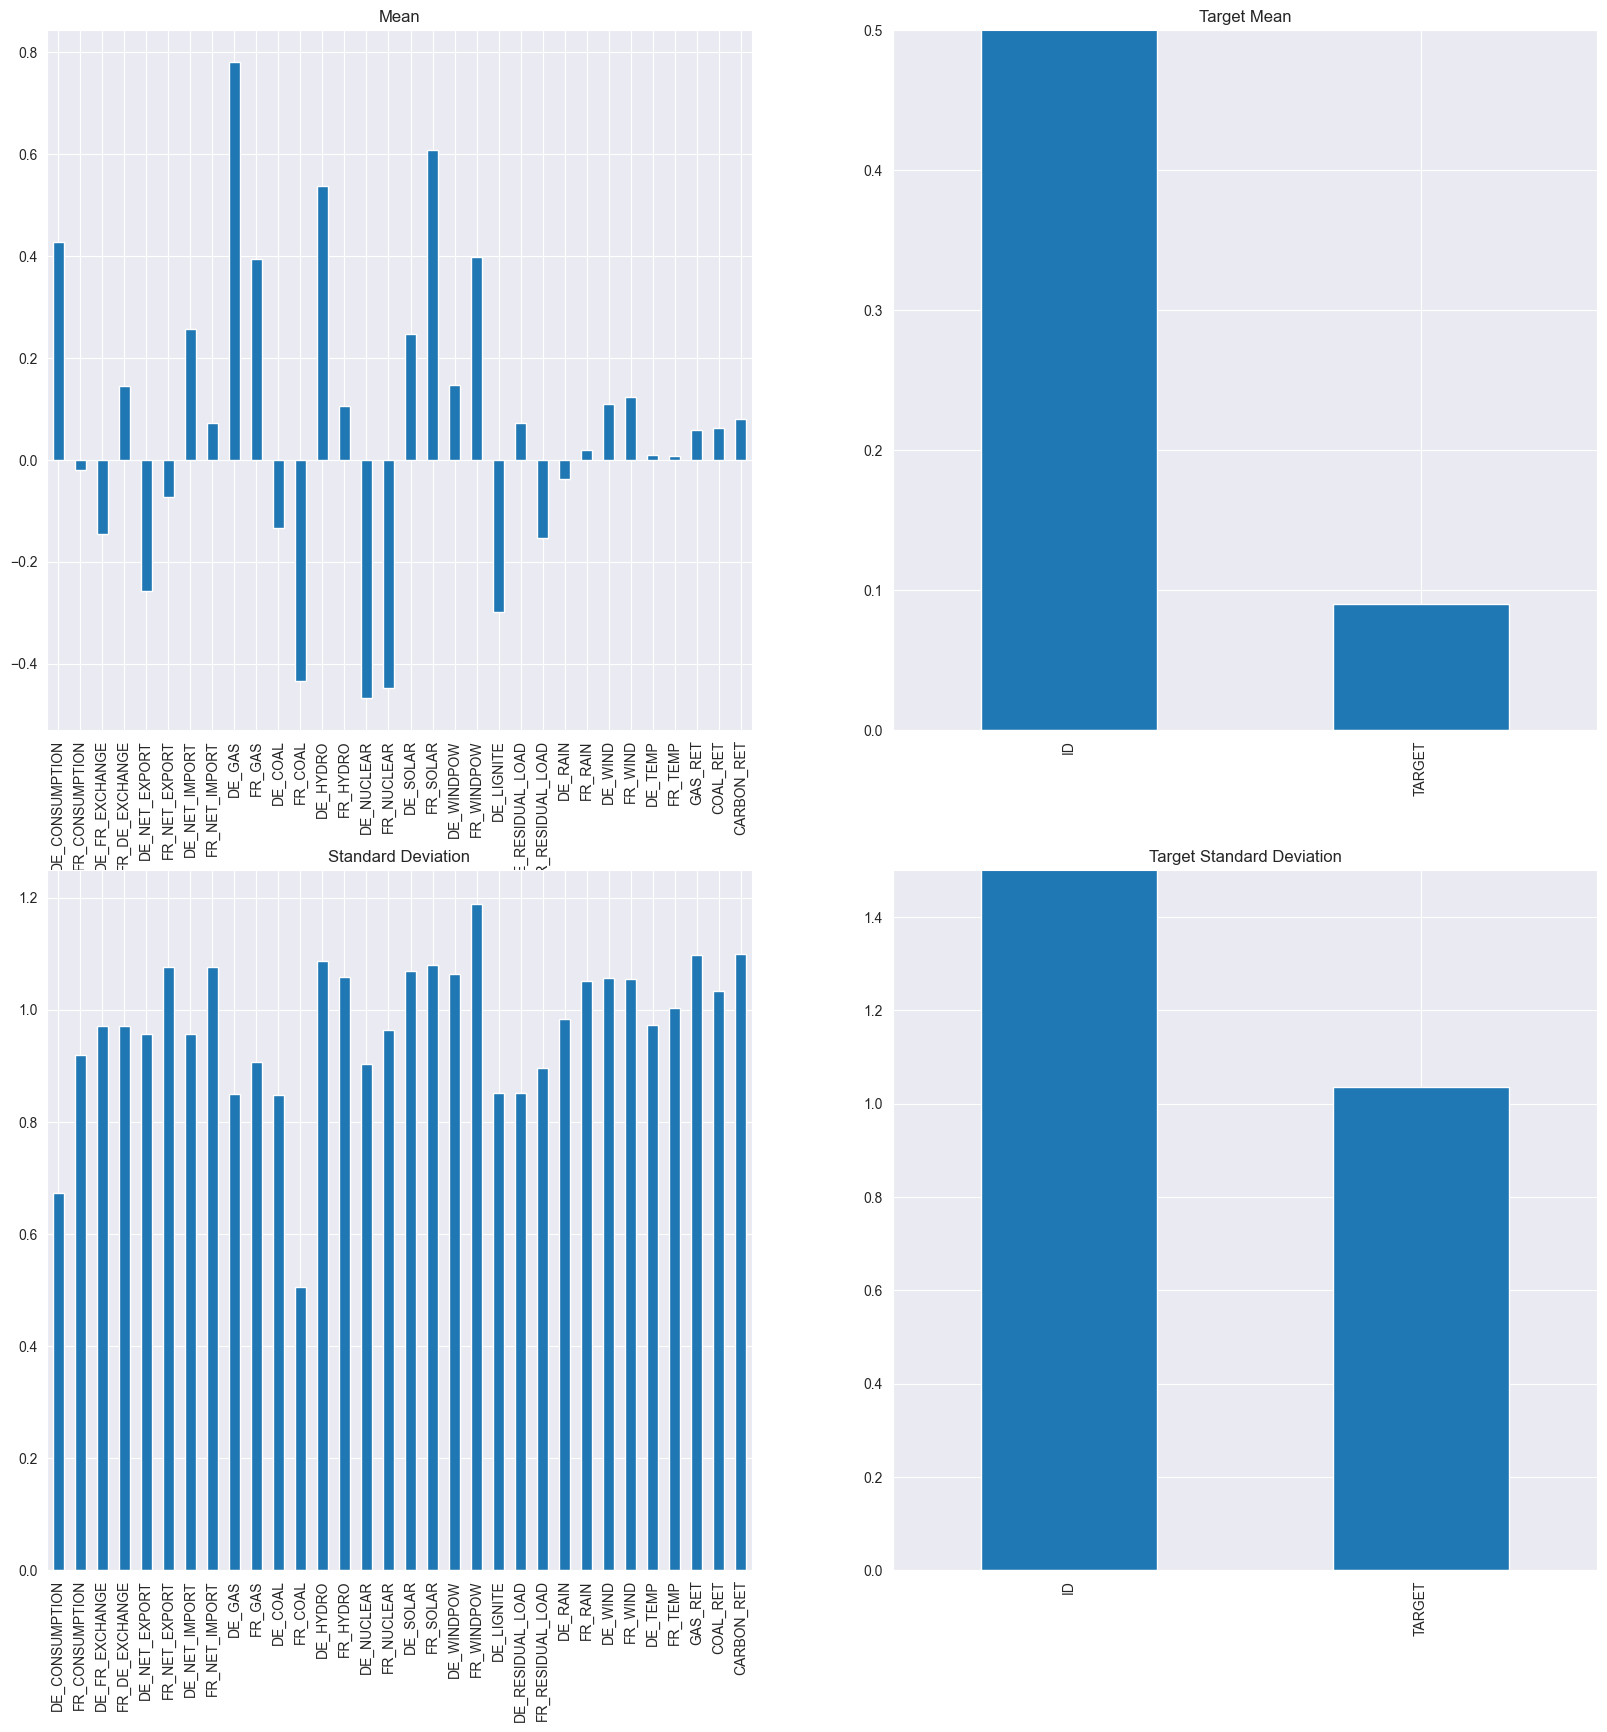

In [557]:
# exclude the county, ID and day number
df = data_x.drop(['ID', 'DAY_ID', 'COUNTRY'], axis=1)

# create sumbplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# plot the mean of the data
df.mean().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Mean')

# plot the mean target variable
data_y.mean().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Target Mean')
axes[0, 1].set_ylim([0, 0.5])

# plot the standard deviation of the data
df.std().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Standard Deviation')

# plot the standard deviation of the target variable
data_y.std().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Target Standard Deviation')
axes[1, 1].set_ylim([0, 1.5])

As we can see, the data is very different from one column to another. We will have to normalize the data.
The mean of the target variable is smaller than 0.1. So the price of electricity generally goes up 10 cents a year. And the standard deviation isa bit higher than 1, so the price of electricity is very volatile.

Let us start by removing the empty cells.

### Removing Empty cells:

We can see that there are empty cells in the data_x dataset:

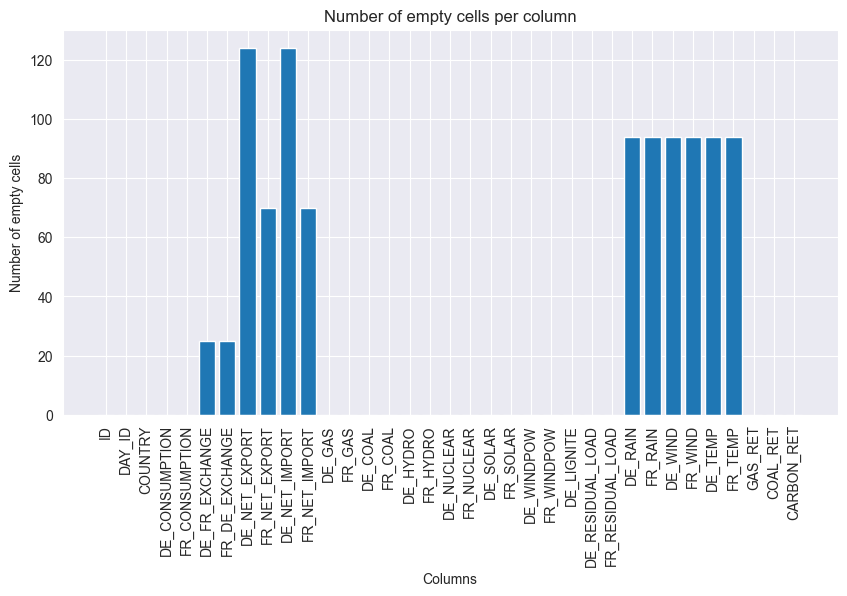

In [558]:
empty_cells = data_x.isnull().sum()
# plot the empty cells
plt.figure(figsize=(10, 5))
plt.bar(empty_cells.index, empty_cells.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Number of empty cells')
plt.title('Number of empty cells per column')
plt.show()

As we can see, there are a lot of empty cells. We will have to deal with them. We decided for this project, to delete the empty lines since we have a lot of data. To do so we use "dropna" function.

In [559]:
# remove the empty cells
data_x = data_x.dropna()

print(data_x.isnull().sum())

ID                  0
DAY_ID              0
COUNTRY             0
DE_CONSUMPTION      0
FR_CONSUMPTION      0
DE_FR_EXCHANGE      0
FR_DE_EXCHANGE      0
DE_NET_EXPORT       0
FR_NET_EXPORT       0
DE_NET_IMPORT       0
FR_NET_IMPORT       0
DE_GAS              0
FR_GAS              0
DE_COAL             0
FR_COAL             0
DE_HYDRO            0
FR_HYDRO            0
DE_NUCLEAR          0
FR_NUCLEAR          0
DE_SOLAR            0
FR_SOLAR            0
DE_WINDPOW          0
FR_WINDPOW          0
DE_LIGNITE          0
DE_RESIDUAL_LOAD    0
FR_RESIDUAL_LOAD    0
DE_RAIN             0
FR_RAIN             0
DE_WIND             0
FR_WIND             0
DE_TEMP             0
FR_TEMP             0
GAS_RET             0
COAL_RET            0
CARBON_RET          0
dtype: int64


As we can see, there are no more empty cells.


### Categories

In this data set, we have a column of categories. We will have to convert this column into numerical values.

In [560]:
# Print the first 5 rows of the data
print(data_x["COUNTRY"].head())

1    FR
2    FR
3    DE
5    FR
6    FR
Name: COUNTRY, dtype: object


To do so, we will use the **OneHotEncoder** from Scikit-Learn. This encoder will create a new column for each category, and will put a 1 if the category is present, and a 0 if not. The two categories are France and Germany.("FR" and "DE")

In [561]:
from sklearn.preprocessing import OneHotEncoder

# Select the column to encode
col = ['COUNTRY']
# Create the encoder
encoder = OneHotEncoder()
# Fit the encoder
encoder.fit(data_x[col])
# Transform the column
encoded = encoder.transform(data_x[col]).toarray()
# Create the new columns
for i, category in enumerate(encoder.categories_[0]):
    data_x[category] = encoded[:, i]
# Drop the old column
data_x = data_x.drop(columns=col)

# Print the first 5 rows of the encoded data
print(data_x.iloc[:, -2:])

       DE   FR
1     0.0  1.0
2     0.0  1.0
3     1.0  0.0
5     0.0  1.0
6     0.0  1.0
...   ...  ...
1487  0.0  1.0
1488  1.0  0.0
1491  1.0  0.0
1492  0.0  1.0
1493  1.0  0.0

[1276 rows x 2 columns]


As we can see, the column "COUNTRY" has been replaced by two columns: "DE" and "FR". If the country is France, then the column "FR" will be equal to 1 and the column "DE" will be equal to 0. If the country is Germany, then the column "DE" will be equal to 1 and the column "FR" will be equal to 0.

### Normalizing the data

In order for our analysis to be correct, we need to normalize the data. In fact, some variables have a much higher scale than others. So, we need to normalize the data. We will use the **std** function from Pandas to normalize the data.

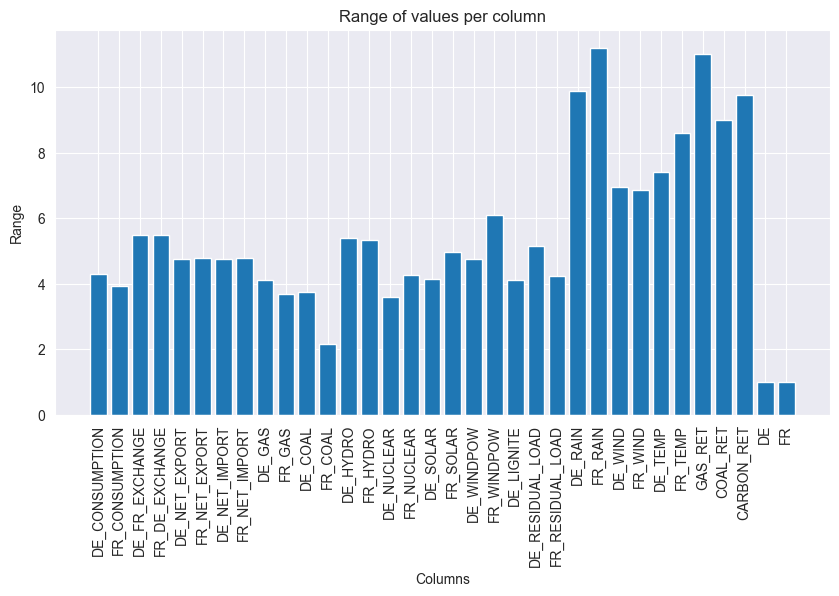

In [562]:
def show_ranges(data):
    # Select the numerical columns to plot
    cols = [col for col in data.columns if col not in ['ID', 'DAY_ID']]

    # get the ranges of all columns
    ranges = data[cols].max() - data[cols].min()

    # plot the ranges
    plt.figure(figsize=(10, 5))
    plt.bar(ranges.index, ranges.values)
    plt.xticks(rotation=90)
    plt.xlabel('Columns')
    plt.ylabel('Range')
    plt.title('Range of values per column')
    plt.show()

show_ranges(data_x)

In [563]:
# Select the numerical columns to normalize
cols = [col for col in data_x.columns if col not in ['ID', 'DAY_ID', 'FR', 'DE']]
# Normalize the data
data_x[cols] = (data_x[cols] - data_x[cols].mean()) / data_x[cols].std()

Now, the data is normalized, let's check the ranges again:

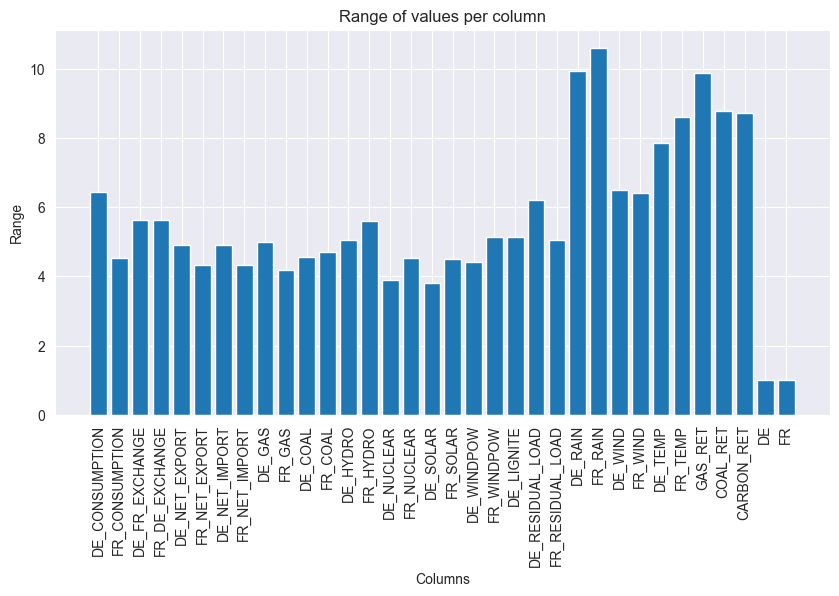

In [564]:
show_ranges(data_x)

As we can see, the ranges are now between 0 and 1. All the data is now normalized, we can proceed to the next part: Removing outliers.

### Removing Outliers
We chose to remove outliers for the following steps. In fact, outliers can have a big impact on the results of the analysis. So, we decided to remove them. We will use the **z-score** to remove the outliers. First let's see the distribution of the variables.

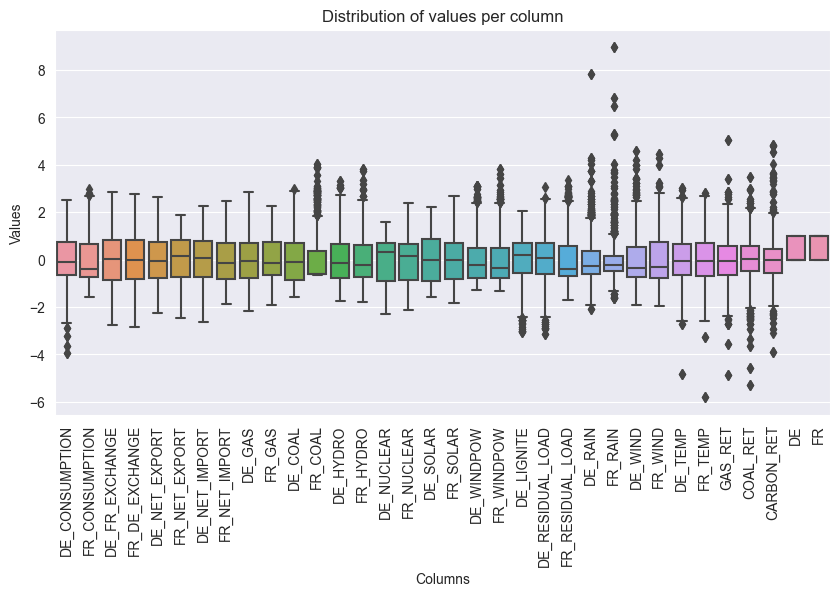

In [565]:
def show_distributions(data):
    # Select the numerical columns to plot
    cols = [col for col in data.columns if col not in ['ID', 'DAY_ID']]
    # Plot the distributions
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data[cols])
    plt.xticks(rotation=90)
    plt.xlabel('Columns')
    plt.ylabel('Values')
    plt.title('Distribution of values per column')
    plt.show()

show_distributions(data_x)

In order to do remove outliers, we will use the **z-score**. The z-score is a statistical measurement that tells us how far a point is from the mean of the dataset. We create a new dataset containing true or false whether each cell is an outlier or not.

In [566]:
# Select the numerical columns to check for outliers
cols = [col for col in data_x.columns if col not in ['ID', 'DAY_ID']]
# Calculate the z-scores for each column
z_scores = np.abs((data_x[cols] - data_x[cols].mean()) / data_x[cols].std())
# Define a threshold for the z-score above which a value is considered an outlier
threshold = 2
# Identify the rows containing outliers
outliers = z_scores[(z_scores > threshold).any(axis=1)]
# Remove the rows containing outliers
data_x = data_x[(z_scores <= threshold).all(axis=1)]

Now, let's see the distribution of the data after removing the outliers:

Number of rows removed:  724


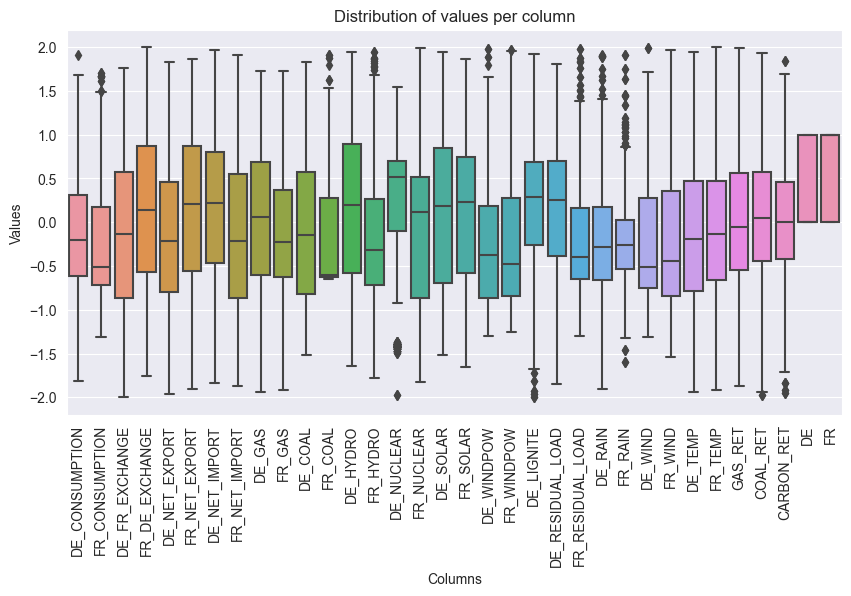

In [567]:
# Print the number of rows removed
print("Number of rows removed: ", len(outliers))
show_distributions(data_x)

As we can see by the output of the above code, the data is now smaller. We removed many rows that contained outliers.

There is one important step we can't skip, we need to remove the lines from the data_y dataset that are not in the data_x dataset. Indeed, we removed some lines from the data_x dataset, so we need to remove the same lines from the data_y dataset.

In [568]:
# remove the lines from the data_y dataset
data_y = data_y[data_y['ID'].isin(data_x['ID'])]

All good ! Now, we can proceed to the next step: Correlation.

## Correlation

Colinearity is when two variables are correlated. In fact, if two variables are correlated, we can remove one of them since it will not bring any new information. We will use the **Pearson correlation coefficient** to find the colinearity between variables. The Pearson correlation coefficient is a measure of the linear correlation between two variables. It has a value between -1 and 1. If the value is close to 1, it means that the two variables are positively correlated. If the value is close to -1, it means that the two variables are negatively correlated. If the value is close to 0, it means that the two variables are not correlated.

We will use the following code to find the colinearity between variables:

In [569]:
# Select the numerical columns to check for colinearity
cols = [col for col in data_x.columns if col not in ['ID', 'DAY_ID']]
# Calculate the Pearson correlation coefficient for each pair of columns
corr_matrix = data_x[cols].corr(method='pearson')

Now that we have calculated the correlation matrix, we use the following code to plot the correlation matrix:


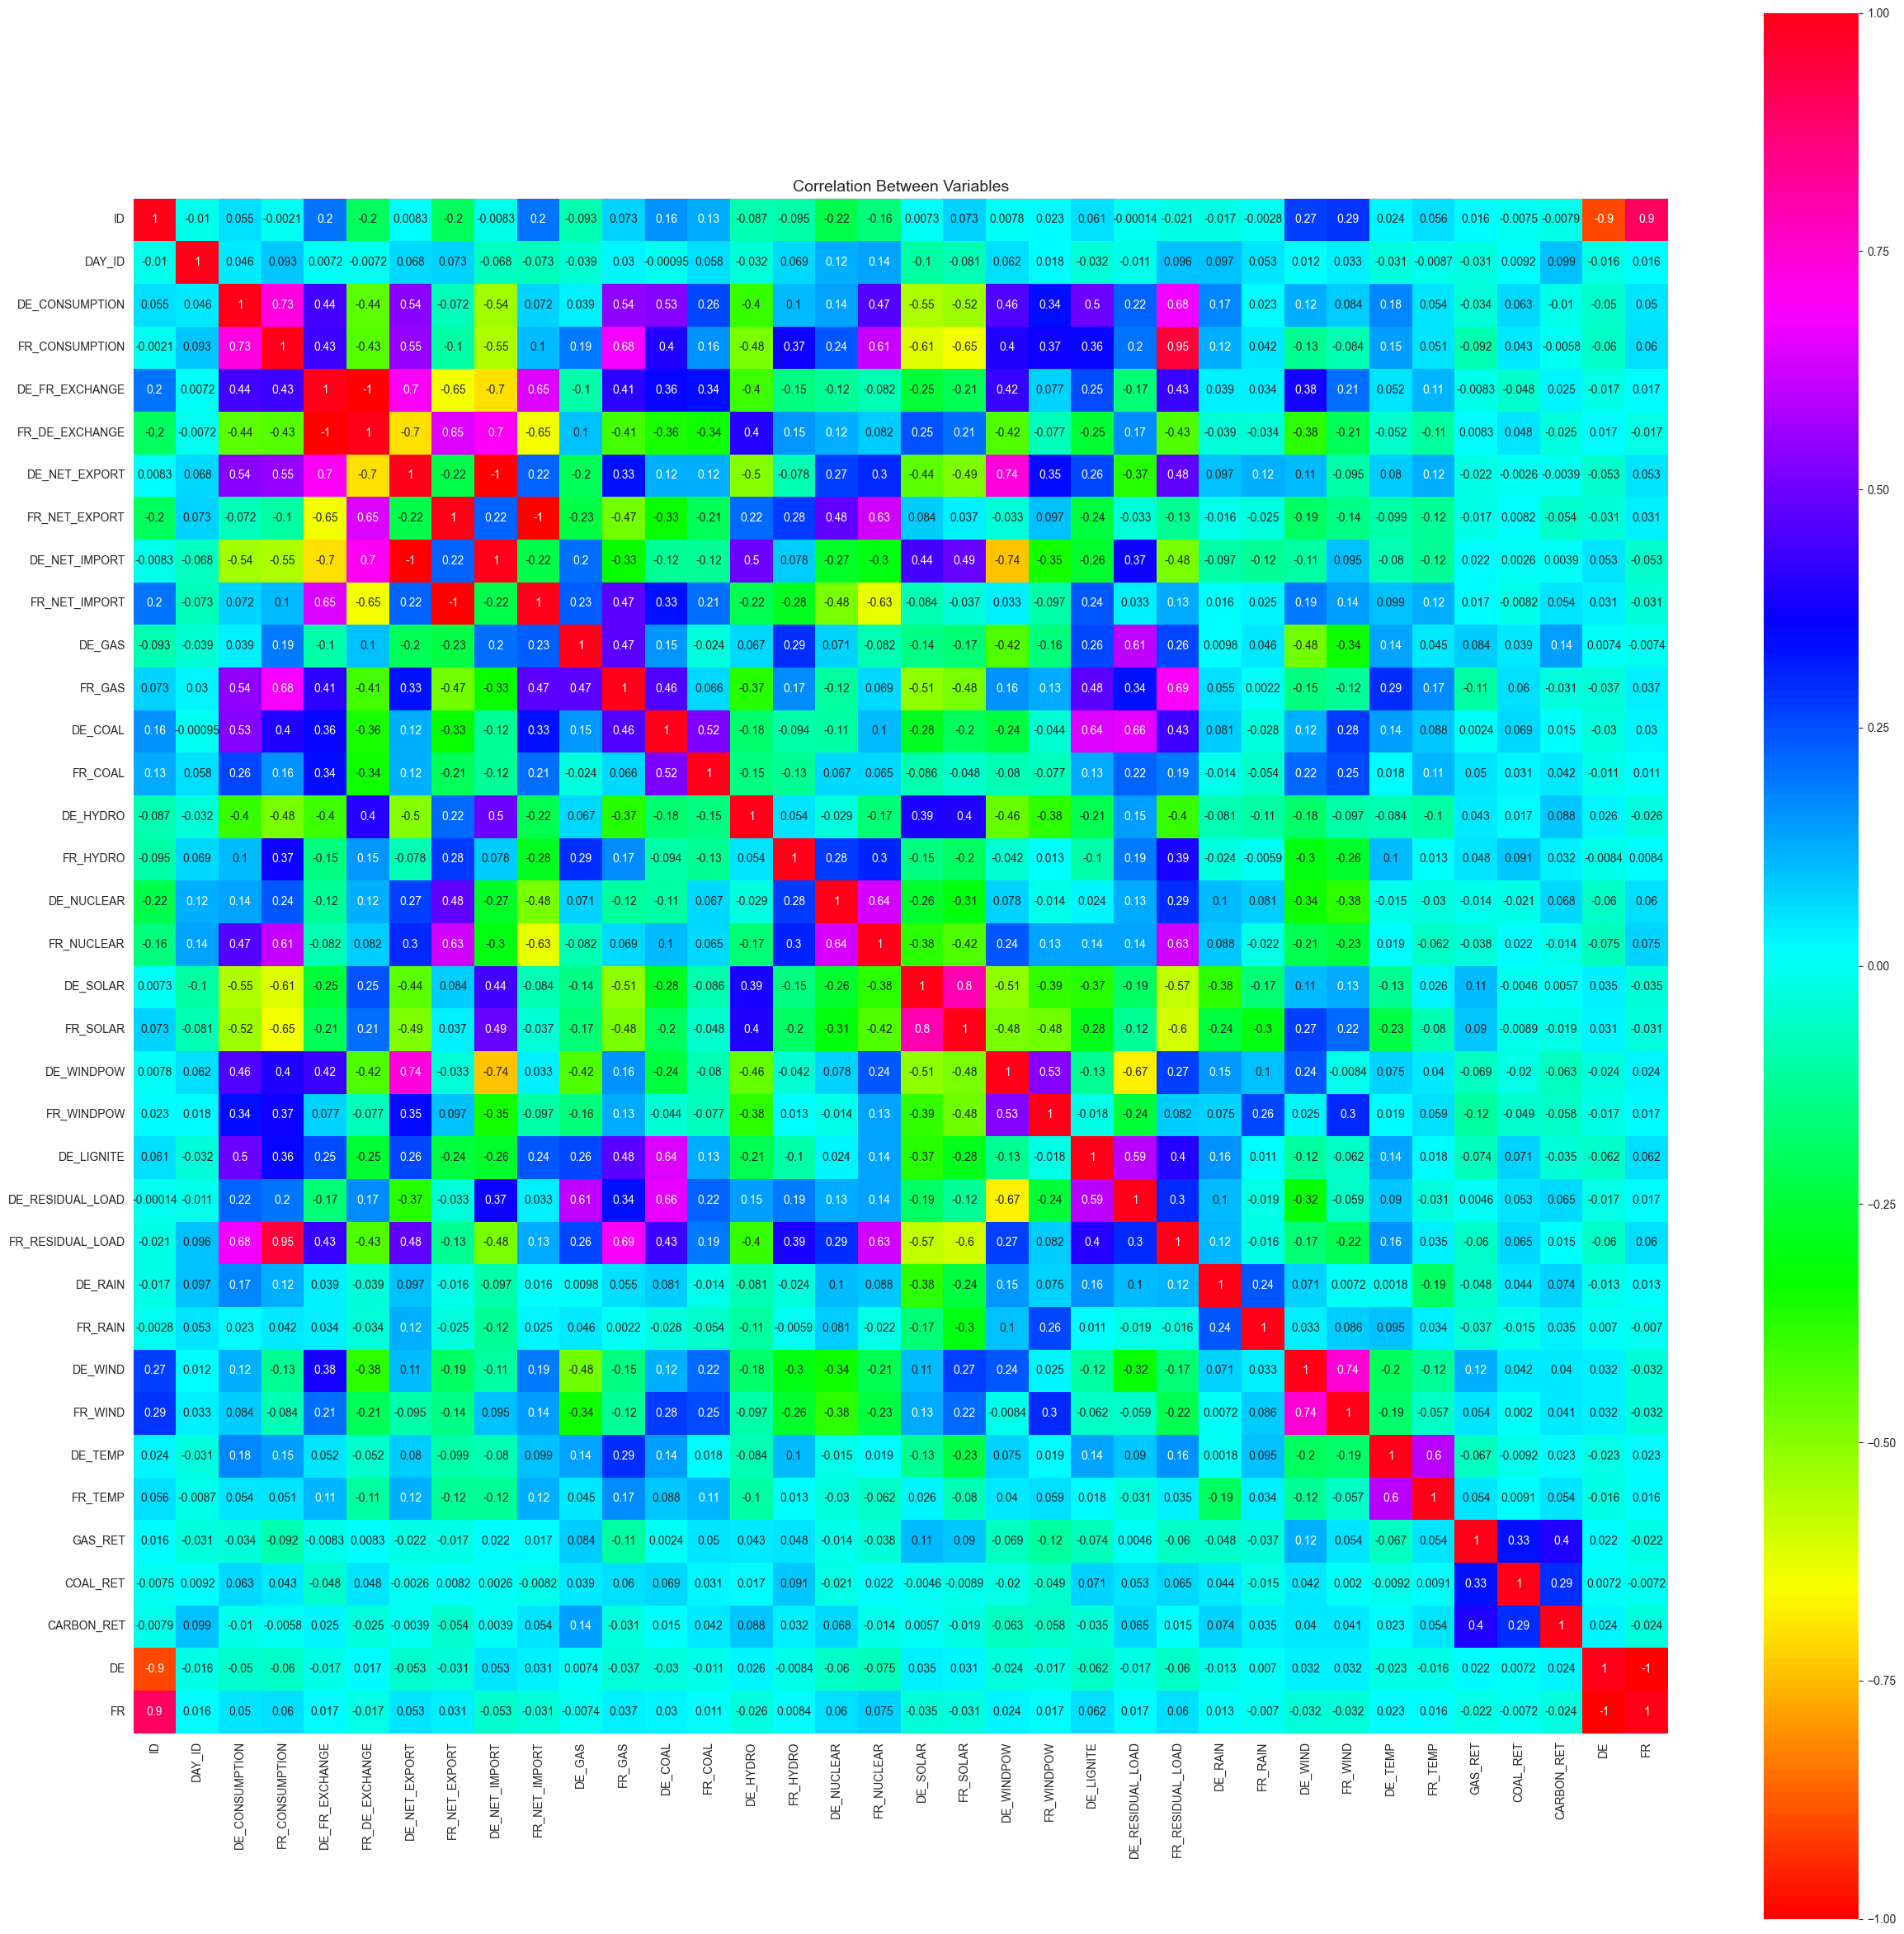

In [570]:
correlation_metrics=data_x.corr()
fig = plt.figure(figsize=(30,30))
sns.heatmap(correlation_metrics,square=True, annot=True, cmap='hsv', vmin=-1, vmax=1)
plt.title('Correlation Between Variables', size=14)
plt.show()

As we can see, there is a strong colinearity between multiple variables. So we remove the variables that are highly correlated. We will remove the variables that have a correlation coefficient higher than 0.8 or lower than -0.8. Let's find the columns that we want to remove with the following code:

In [571]:
# find the columns to remove
cols_to_remove = []
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            cols_to_remove.append(cols[j])

# print the columns to remove
print(cols_to_remove)

['FR_RESIDUAL_LOAD', 'FR_DE_EXCHANGE', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'FR']


Now, we remove the columns that we found with the following code:

In [572]:
# remove the columns
data_x = data_x.drop(cols_to_remove, axis=1)

Now, let's see the correlation matrix again:

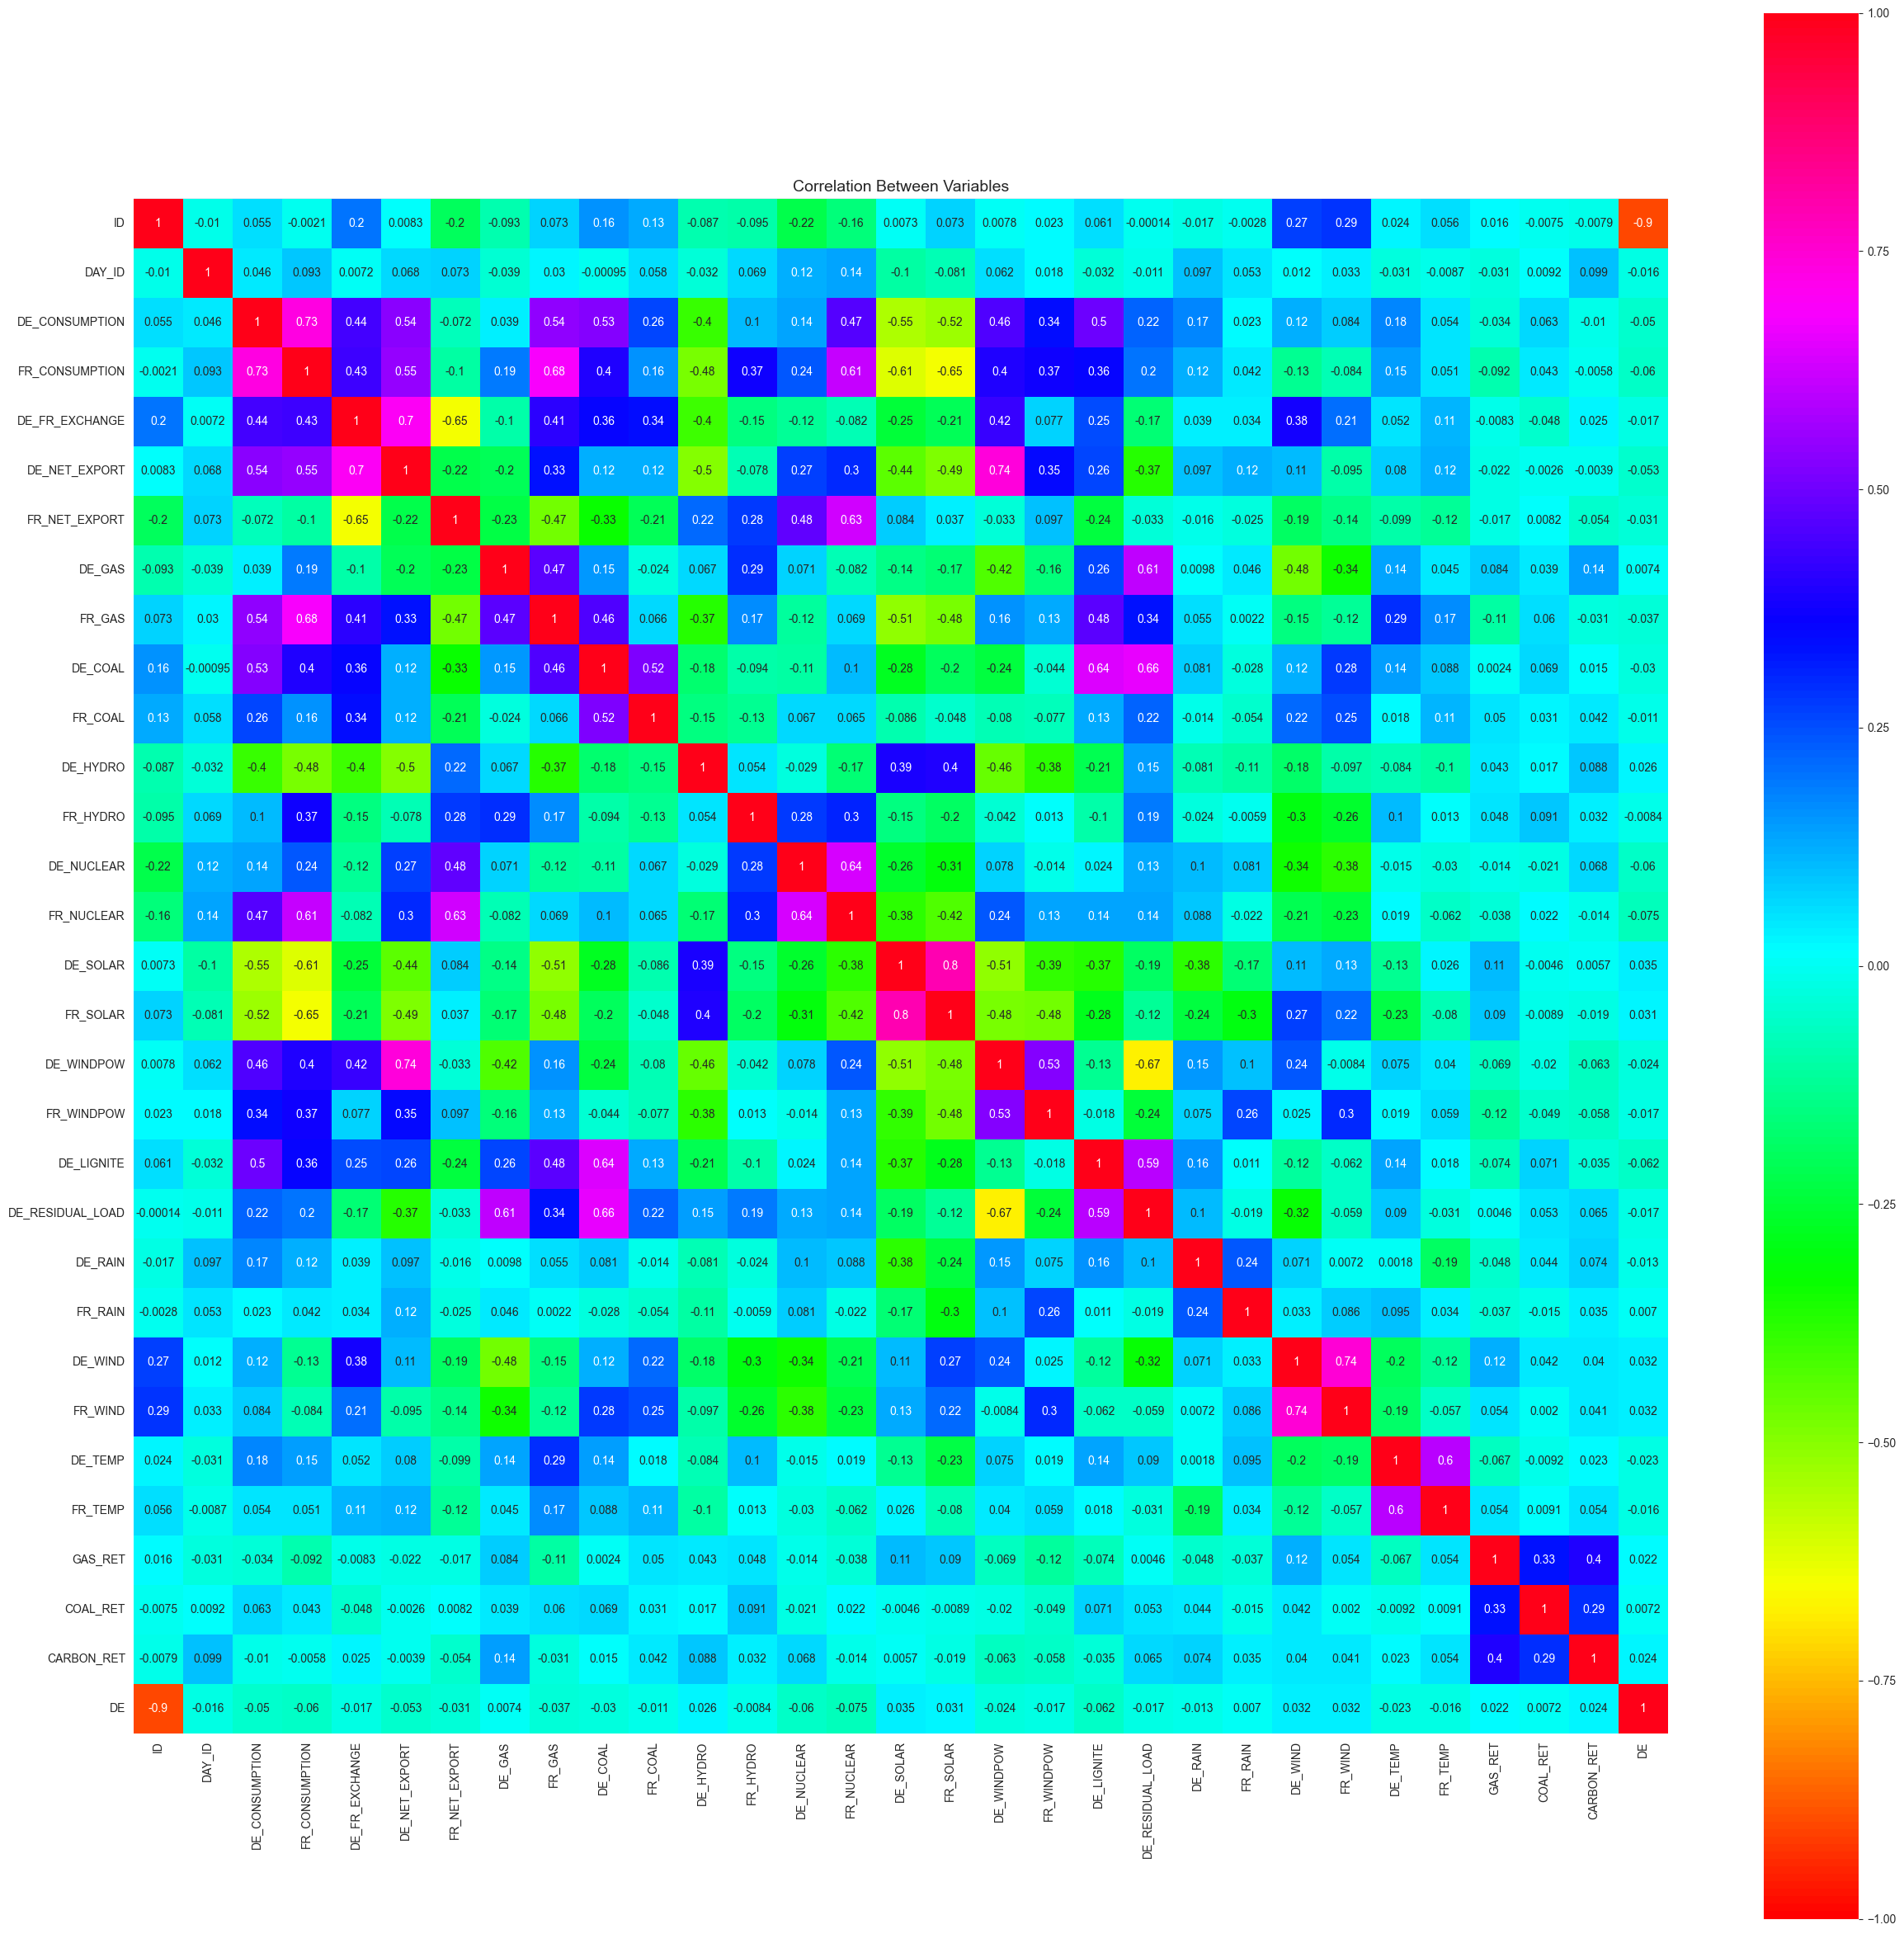

In [573]:
correlation_metrics=data_x.corr()
fig = plt.figure(figsize=(30,30))
sns.heatmap(correlation_metrics,square=True, annot=True, cmap='hsv', vmin=-1, vmax=1)
plt.title('Correlation Between Variables', size=14)
plt.show()

All good ! There is no more colinearity between variables.

## Feature Selection

As we can see, we still have many variables, so we will use feature selection to reduce the number of variables. We will use the **Random Forest** algorithm to find the most important variables. The Random Forest algorithm is an ensemble learning method that uses decision trees. It creates a large number of decision trees and then combines them to get a more accurate prediction. In order to do so, we use the following function:

In [574]:
# Import the random forest model
from sklearn.ensemble import RandomForestRegressor

def get_importance_of_variables(data_x, data_y):
    # Instantiate the random forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    rf.fit(data_x, data_y['TARGET'])

    # Get the feature importances
    feature_importances = rf.feature_importances_

    # Get the indices of the most important variables
    indices = feature_importances.argsort()[::-1]

    # Get the names of the most important variables
    names = [data_x.columns[i] for i in indices]

    # Create a pandas DataFrame to store the feature importances
    importance_df = pd.DataFrame({'feature': names, 'importance': feature_importances[indices]})

    return importance_df


importance = get_importance_of_variables(data_x, data_y)

Now that we have the most important variables, let's plot them !


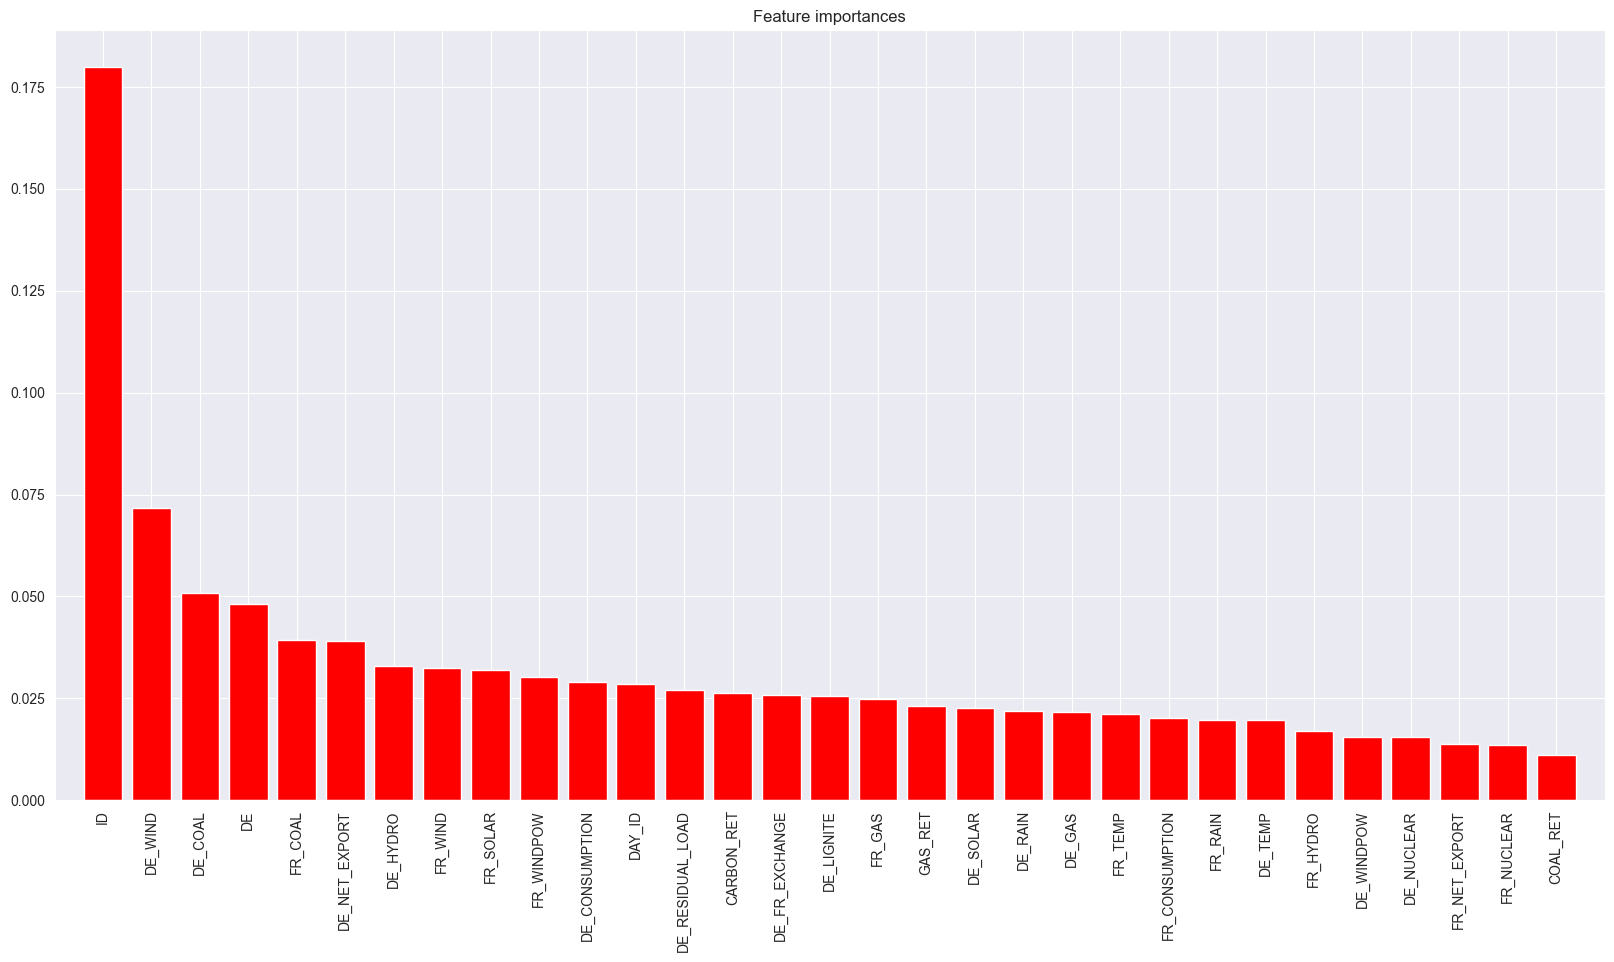

In [575]:
# Plot the feature importances
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(data_x.shape[1]), importance['importance'], color="r", align="center")
plt.xticks(range(data_x.shape[1]), importance['feature'], rotation='vertical')
plt.xlim([-1, data_x.shape[1]])
plt.show()

As we can see, not all features are important. So we will remove the features that are not important. We will keep only the features that have an importance higher than 0.025. We will use the following code to remove the features that are not important:


In [576]:
# Remove the features that have an importance lower than 0.025
cols_to_remove = importance[importance['importance'] < 0.025]['feature'].tolist()
data_x = data_x.drop(cols_to_remove, axis=1)

Now, let's check the feature importances again:


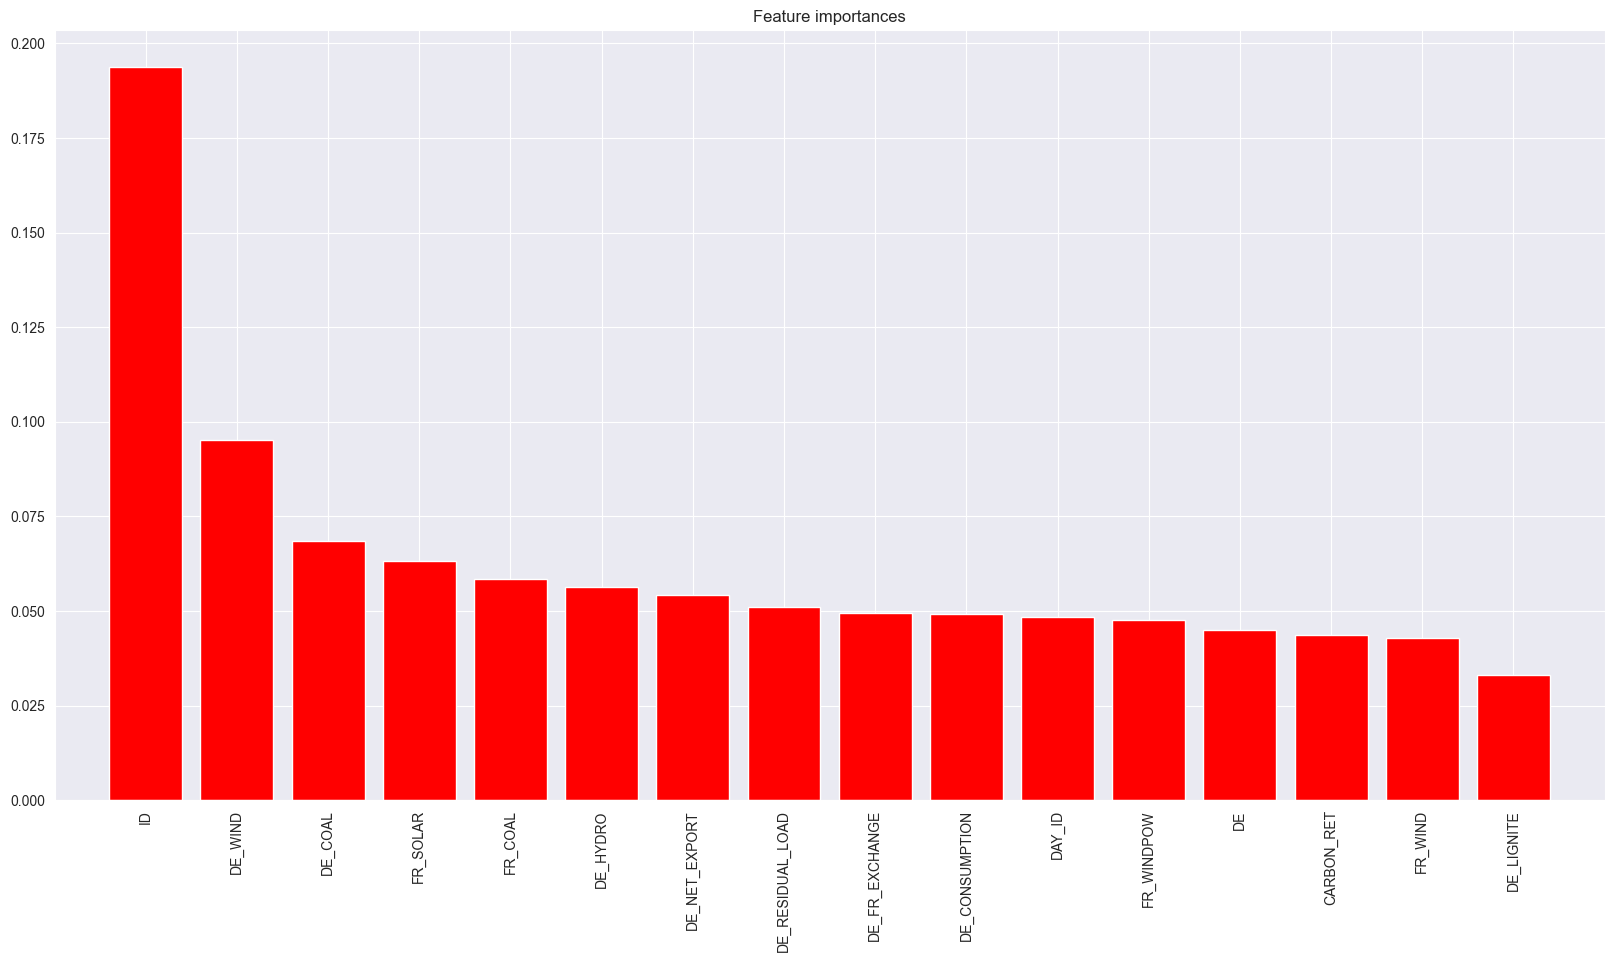

In [577]:
importance = get_importance_of_variables(data_x, data_y)

# Plot the feature importances
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(data_x.shape[1]), importance['importance'], color="r", align="center")
plt.xticks(range(data_x.shape[1]), importance['feature'], rotation='vertical')
plt.xlim([-1, data_x.shape[1]])
plt.show()

### Target Variable Analysis

Now the data is clean. We have:
- removed the lines containing missing values
- removed the variables that are highly correlated
- removed the variables that are not important
- normalized the data
- removed the outliers

Now, let's analyze the target variable. Let's see the distribution of the target variable with the following code:

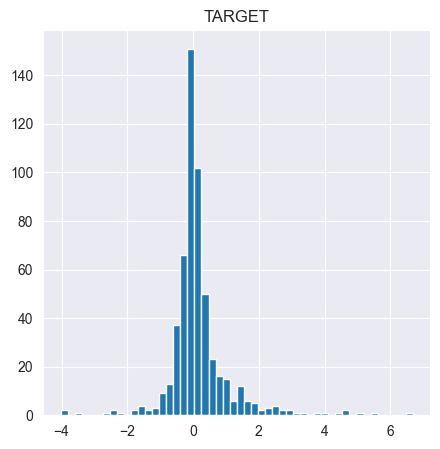

In [578]:
# show only TARGET
data_y.hist(bins=50, figsize=(5, 5), column='TARGET')
plt.show()

As we can see, the distribution of the target variable is not normal. The values are mainly between -2 and 2. They represent the variation of the price of electricity. The values are negative when the price of electricity decreases and positive when the price of electricity increases. The values are between -2 and 2 because the price of electricity does not vary a lot. Indeed, the price of electricity is quite stable.

Let's seperate the target variable into the two countries.

In [579]:
# get the id's of the lines with germany column = 1.O
germany_ids = data_x[data_x['DE'] == 1.0].index.tolist()
germany_target = data_y.loc[germany_ids]

# get the id's of the lines with germany column != 1.O
france_ids = data_x[data_x['DE'] != 1.0].index.tolist()
france_target = data_y.loc[france_ids]

What we can do now, is sort the target variable by ascending ID. This way, we should have the target variable sorted by date. This is an asumption, nothing mentions that the ID's are in chronological order.

In [580]:
# sort the target variables by ascending ID
germany_target = germany_target.sort_index()
france_target = france_target.sort_index()

# transform the values. We want to have a estimate of the price, not the variation of the price
germany_target['TARGET'] = germany_target['TARGET'].cumsum()
france_target['TARGET'] = france_target['TARGET'].cumsum()

Now that we have the variables "sorted by date", we can plot them as a curve to see the evolution of the price of electricity over time.

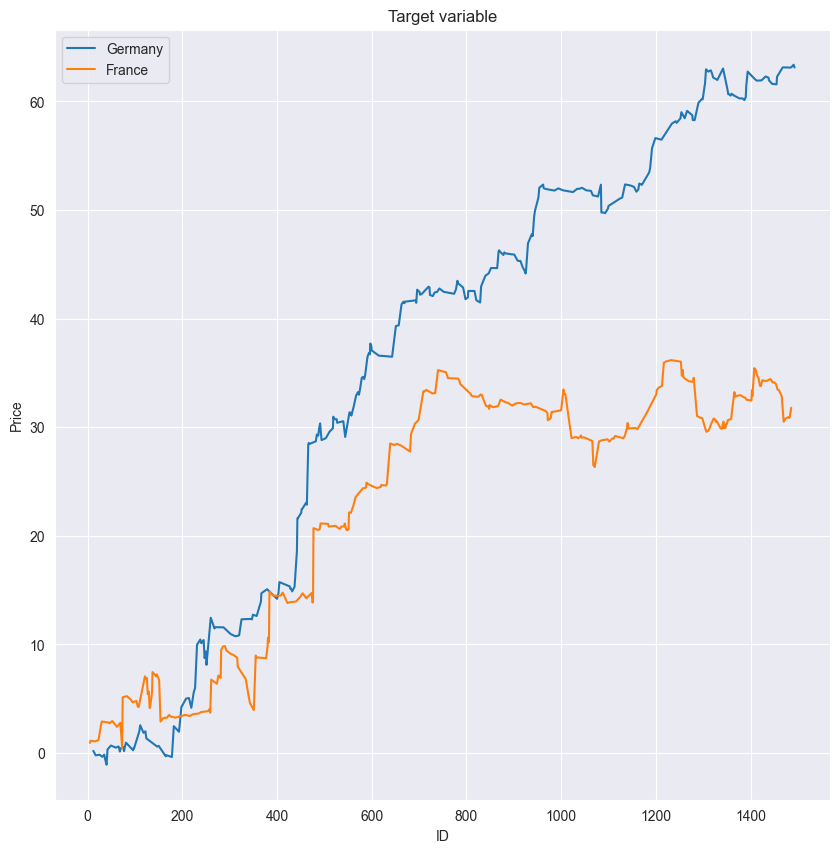

In [581]:
# plot the target variables as a curve on the same plot
plt.figure(figsize=(10, 10))
plt.title("Target variable")
plt.plot(germany_target['TARGET'], label='Germany')
plt.plot(france_target['TARGET'], label='France')
plt.xlabel('ID')
plt.ylabel('Price')
plt.legend()
plt.show()

From this graph, we can see the global variation of the prices of electricity over time. It seems that the prices are augmenting. We also see that about at ID 800, the price of electricity in Germany keeps increasing while the price of electricity in France stabilises. This is a very interesting point. We will see later if we can find the reason of this. We may also see sort of periods on the curves. Of course, because of the amount of use of electricity, the price fluctuates during the winter and the summer. It is hard to say if this is truly the case because we do not have enough knowledge about the data. Are the prices recorded every month ? year ? day ? hour ? minute ? second ? We do not know. We will see later if we can find the answer to this question.
#
Now let's see how this target variable is correlated with the other variables. We start by calculating the correlation:

In [582]:
corr_matrix = data_x.corrwith(data_y['TARGET'], method='pearson')
# sort the correlations
corr_matrix.sort_values(inplace=True)

Now, let's plot the correlation between the target variable and the other variables:

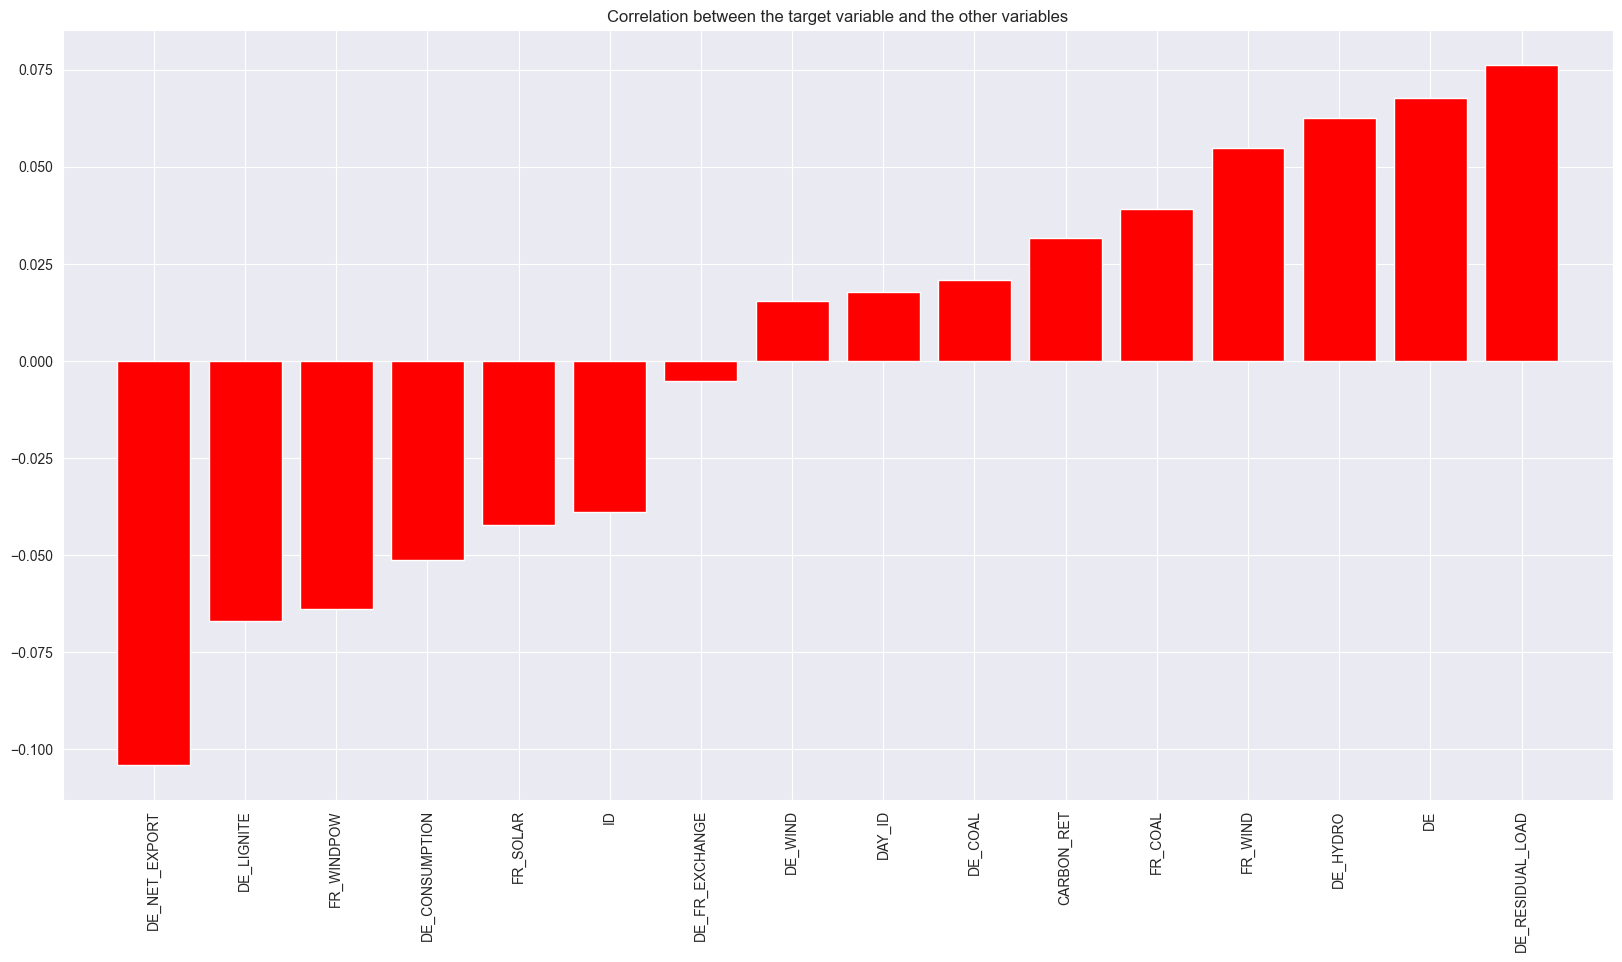

In [583]:
plt.figure(figsize=(20, 10))
plt.title("Correlation between the target variable and the other variables")
plt.bar(range(len(corr_matrix)), corr_matrix, color="r", align="center")
plt.xticks(range(len(corr_matrix)), corr_matrix.index, rotation='vertical')
plt.xlim([-1, len(corr_matrix)])
plt.show()

Now we can clearly see which variables are correlated with the target variable. As we can observe, the correlations are quite low. This was expected because the price of electricity is quite stable. It was also expected because otherwise, this project would have been too simple.
#
### Testing and Training Data

We will now split our data into a training set and a testing set. We will use the following code to do so:


In [584]:
# Import the train_test_split function from sklearn
from sklearn.model_selection import train_test_split

# Split the data into a training set and a testing set
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

# Data Modeling and Evaluation
Now, it is time for the fun part: the modeling and the evaluation of the models. We will use the following models:
- Linear Regression
- Regularized Linear Regression
- K-Nearest Neighbors for Regression
- Decision Tree for Regression
- Random Forest for Regression

For each model, we will:
- train the model
- make predictions
- evaluate the performance of the model, using the mean squared error, spearman correlation, and the R2 score

For each of our models, we will need to import many models and scripts. We will use the following code to import the libraries that we will need:
from sklearn.metrics import mean_squared_error

In [585]:
# Import the spearmanr function from scipy
from scipy.stats import spearmanr
# Import the r2_score function from sklearn
from sklearn.metrics import r2_score
# Import mean_squared_error from  sklearn
from sklearn.metrics import mean_squared_error
# Import the LinearRegression model from sklearn
from sklearn.linear_model import LinearRegression
# Import the Ridge model from sklearn
from sklearn.linear_model import Ridge, Lasso
# Import the KNeighborsRegressor model from sklearn
from sklearn.neighbors import KNeighborsRegressor
# Import the DecisionTreeRegressor model from sklearn
from sklearn.tree import DecisionTreeRegressor
# Import the RandomForestRegressor model from sklearn
from sklearn.ensemble import RandomForestRegressor

# Creating the models

We will start by creating the models. We will use the following code:

In [586]:
# Instantiate the LinearRegression model
lr = LinearRegression()

# Instantiate the Ridge model
ridge = Ridge()

# Instantiate the Lasso model
lasso = Lasso()

# Instantiate the KNeighborsRegressor model
knn = KNeighborsRegressor()

# Instantiate the DecisionTreeRegressor model
dt = DecisionTreeRegressor()

# Instantiate the RandomForestRegressor model
rf = RandomForestRegressor()

# Training the models

Now that we have created the models, we will train them. We will use the following code:



In [587]:
lr.fit(data_x_train, data_y_train['TARGET'])
ridge.fit(data_x_train, data_y_train['TARGET'])
lasso.fit(data_x_train, data_y_train['TARGET'])
knn.fit(data_x_train, data_y_train['TARGET'])
dt.fit(data_x_train, data_y_train['TARGET'])
rf.fit(data_x_train, data_y_train['TARGET']);

# Making predictions

Now that we have trained the models, we will make predictions.


In [588]:
# Make predictions
lr_predictions = lr.predict(data_x_test)
ridge_predictions = ridge.predict(data_x_test)
lasso_predictions = lasso.predict(data_x_test)
knn_predictions = knn.predict(data_x_test)
dt_predictions = dt.predict(data_x_test)
rf_predictions = rf.predict(data_x_test)

# Evaluating the models

Now that we have made predictions, we will evaluate the performance of the models. In order to do so, we will create a function to evaluate the predictions. We will use the following code:


In [589]:
def evaluateModel(modelname, predictions, results):
    # Calculate the mean squared error
    mse = mean_squared_error(data_y_test['TARGET'], predictions)
    # Calculate the spearman correlation
    spearman = spearmanr(data_y_test['TARGET'], predictions)
    # Calculate the r2 score
    r2 = r2_score(data_y_test['TARGET'], predictions)
    results = pd.concat([results, pd.DataFrame([[modelname, mse, spearman[0], r2, predictions]], columns=['Model', 'MSE', 'Spearman', 'R2', 'predictions'])])
    return results

Now we will call this function for each model. And save all of the results in a dataframe. We will use the following code:

In [590]:
results = pd.DataFrame(columns=['Model', 'MSE', 'Spearman', 'R2', 'predictions'])

# evaluate linear regression
results = evaluateModel("Linear Regression", lr_predictions, results)

# evaluate ridge regression
results = evaluateModel("Ridge Regression", ridge_predictions, results)

# evaluate lasso regression
results = evaluateModel("Lasso Regression", lasso_predictions, results)

# evaluate knn regression
results = evaluateModel("KNN Regression", knn_predictions, results)

# evaluate decision tree regression
results = evaluateModel("Decision Tree Regression", dt_predictions, results)

# evaluate random forest regression
results = evaluateModel("Random Forest Regression", rf_predictions, results)

Let's plot the predictions to the actual values. We will use the function:

In [591]:
def plotPredictions(pos, actual, predictions, title):
    plt.subplot(pos)
    plt.scatter(actual, predictions)
    plt.xlabel('Actual')
    plt.ylabel('Predictions')
    # draw the x=y line (line of perfect predictions) in red
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r')
    plt.title(title)

Now we will call this function for each model.

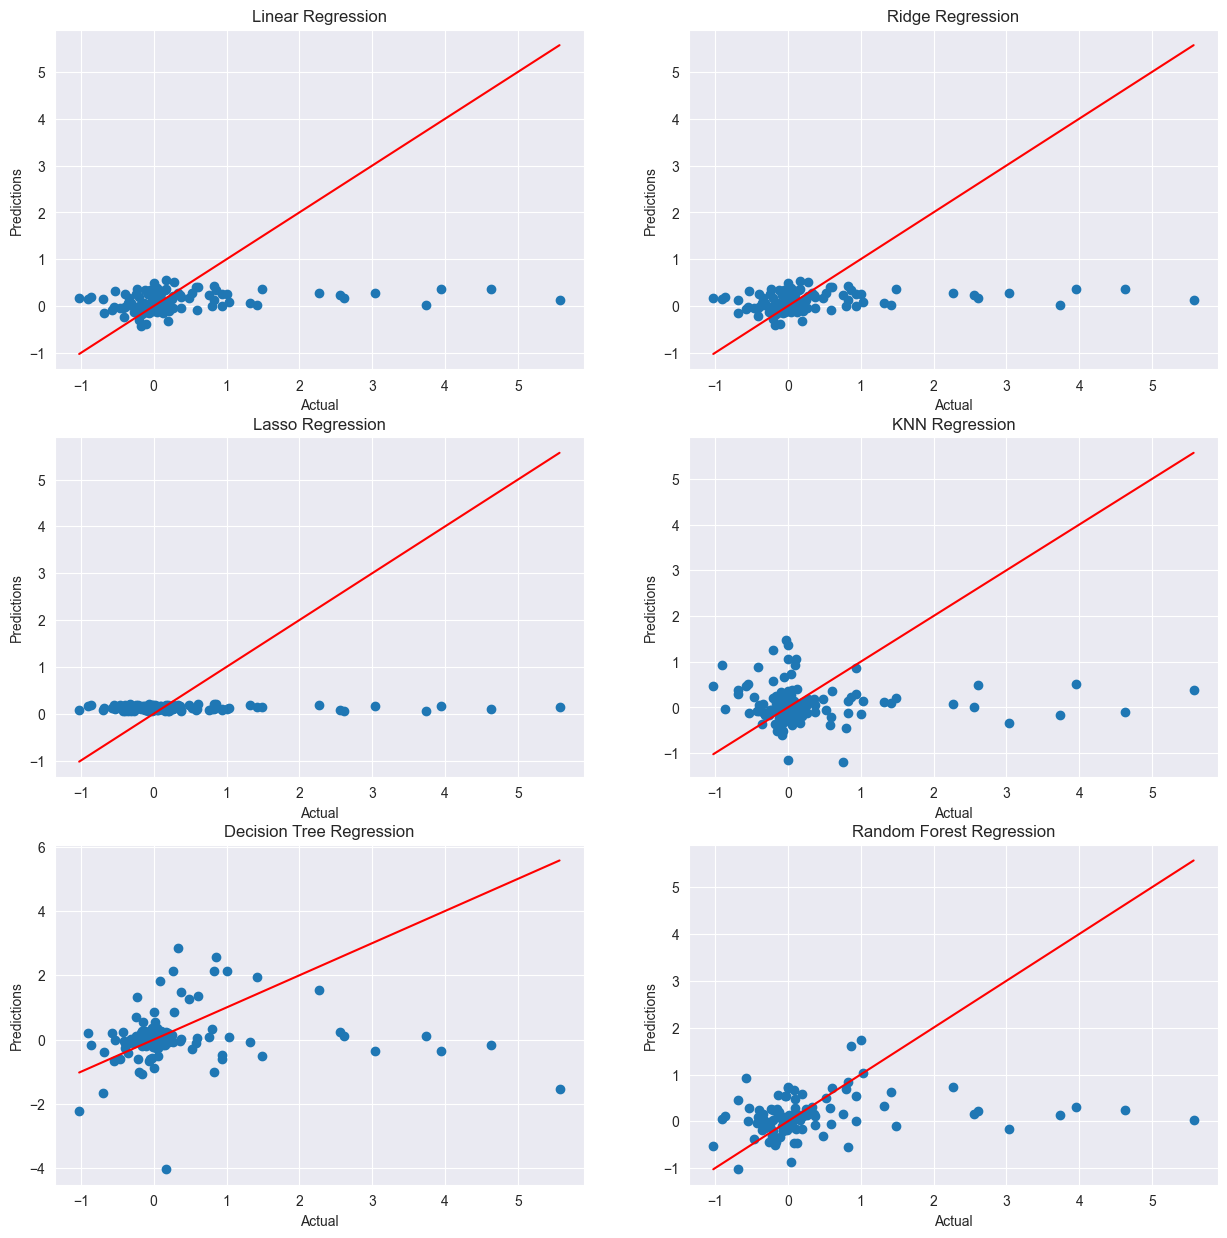

In [592]:
# create subplot, 3 row, 2 columns
plt.subplots(3, 2, figsize=(15, 15))

# plot linear regression predictions
plotPredictions(321, data_y_test['TARGET'], lr_predictions, 'Linear Regression')

# plot ridge regression predictions
plotPredictions(322, data_y_test['TARGET'], ridge_predictions, 'Ridge Regression')

# plot lasso regression predictions
plotPredictions(323, data_y_test['TARGET'], lasso_predictions, 'Lasso Regression')

# plot knn regression predictions
plotPredictions(324, data_y_test['TARGET'], knn_predictions, 'KNN Regression')

# plot decision tree regression predictions
plotPredictions(325, data_y_test['TARGET'], dt_predictions, 'Decision Tree Regression')

# plot random forest regression predictions
plotPredictions(326, data_y_test['TARGET'], rf_predictions, 'Random Forest Regression')

# show the plot
plt.show()

Now we can plot the results. We will use the following code:


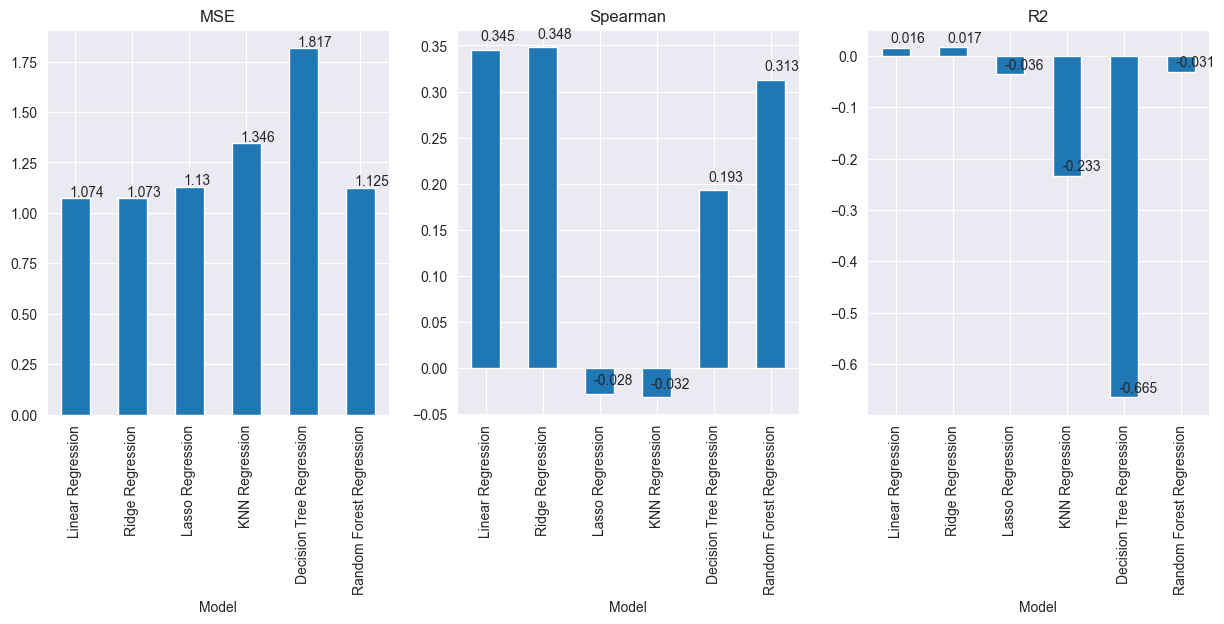

In [593]:
# Import the pyplot module from matplotlib
import matplotlib.pyplot as plt

# Create a figure and add subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the MSE
results.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
for i, v in enumerate(results['MSE']):
    axs[0].text(i - .1, v + .01, str(round(v, 3)))


# Plot the Spearman
results.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
for i, v in enumerate(results['Spearman']):
    axs[1].text(i - .1, v + .01, str(round(v, 3)))

# Plot the R2
results.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)
for i, v in enumerate(results['R2']):
    axs[2].text(i - .1, v + .01, str(round(v, 3)))

# Show the plot
plt.show()

# Hyperparameter tuning

Now that we have evaluated the models, we will try to improve the performance of the models by tuning their hyperparameters. We can do so by using GridSearchCV. For each model, we will try to find the best hyperparameters. First we need to import GridSearchCV from sklearn.

We also need to define the following function, we will show you why just under !


In [594]:
# Import GridSearchCV from sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import sklearn.metrics

We will use the following function to calculate the spearman correlation. We will use this function to evaluate the models. Our goal here is to find the correct parameters to maximise the spearmann correlation. We will use the following function:

In [595]:
def spearman_score(y_pred, y_true):
    return spearmanr(y_true, y_pred)[0]


## Linear Regression

For the linear regression, there are no hyperparameters to tune. So we will just use the model as it is. let's do the next model.


# Ridge Regression

Now we will tune the hyperparameters of the ridge regression model. We will use the following code:


In [596]:
import sklearn.metrics

# parameters for Ridge
param_grid = {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'alpha': np.logspace(-10, 10),
}
# Create a GridSearchCV object
grid = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(spearman_score, greater_is_better=True),
    n_jobs=-1,
    return_train_score=True
)

# Fit the GridSearchCV object to the data
grid.fit(data_x_train, data_y_train['TARGET']);

So here are the best parameters for the ridge regression model.

In [597]:
print("Previous parameters :")
print(ridge.get_params())

print("New parameters :")
print(grid.best_estimator_.get_params())

print("Best parameters :")
print(grid.best_params_);

Previous parameters :
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
New parameters :
{'alpha': 10.481131341546874, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'lsqr', 'tol': 0.0001}
Best parameters :
{'alpha': 10.481131341546874, 'solver': 'lsqr'}


Now let's check the performance of the model for each parameter. We will first add the results to the results dataframe, and plot the predictions.

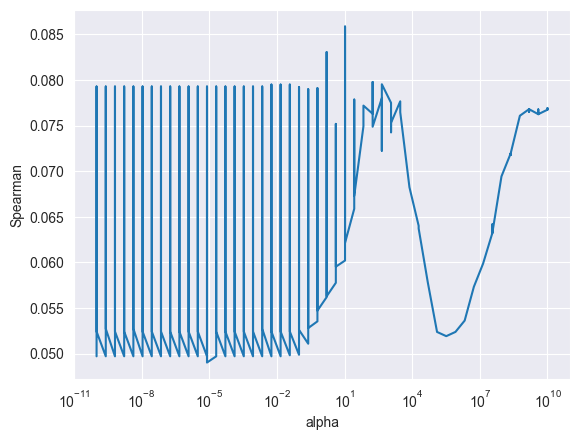

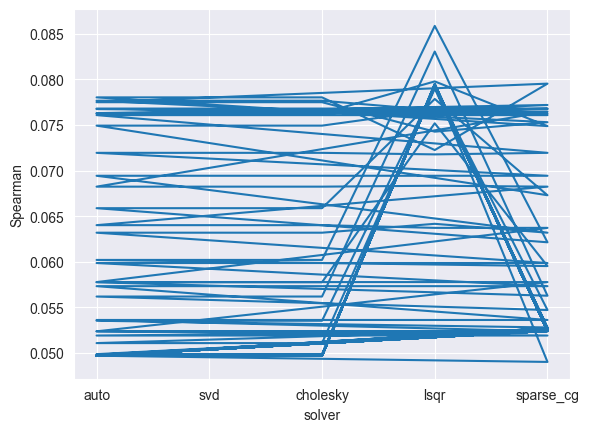

In [598]:
r = pd.DataFrame(grid.cv_results_)
# plot the performance of model depending on alpha
plt.plot(r['param_alpha'], r['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Spearman')
plt.xscale('log')
plt.show()

# plot the performance of model depending on solver
plt.plot(r['param_solver'], r['mean_test_score'])
plt.xlabel('solver')
plt.ylabel('Spearman')
plt.show()

Now we can use the model with the best parameters on our data again, and evaluate the performance of the model.

In [599]:
predictions_tuned_ridge = grid.best_estimator_.predict(data_x_test)
results = evaluateModel("Ridge Regression (tuned)", predictions_tuned_ridge, results)

Let's plot the predictions to the actual values, and compare them with the predictions of the ridge regression model.

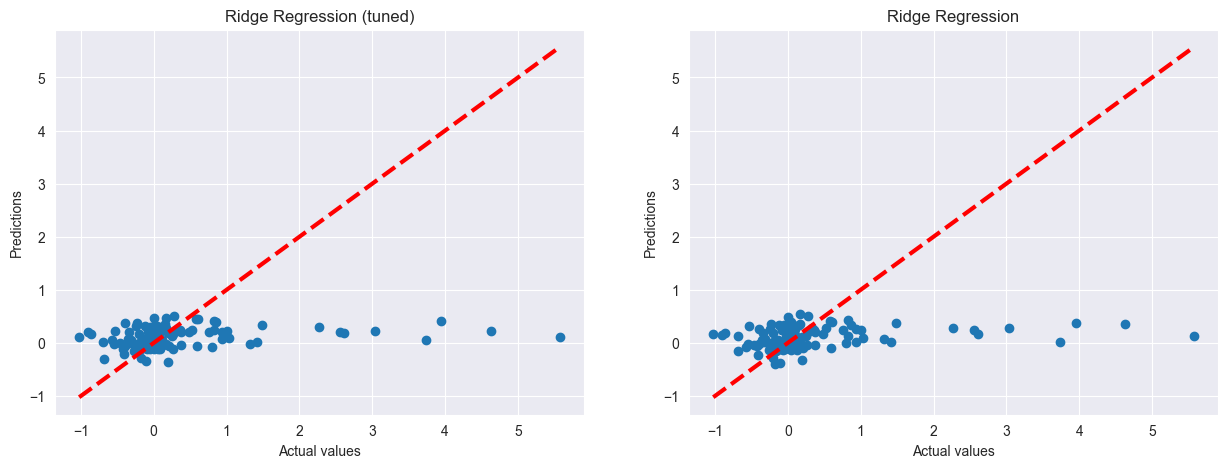

In [600]:
# create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the predictions to the actual values on the new model
axs[0].scatter(data_y_test['TARGET'], predictions_tuned_ridge)
axs[0].plot([data_y_test['TARGET'].min(), data_y_test['TARGET'].max()], [data_y_test['TARGET'].min(), data_y_test['TARGET'].max()], 'r--', lw=3)
axs[0].set_title('Ridge Regression (tuned)')
axs[0].set_xlabel('Actual values')
axs[0].set_ylabel('Predictions')

# Plot the predictions to the actual values on the old model
axs[1].scatter(data_y_test['TARGET'], ridge_predictions)
axs[1].plot([data_y_test['TARGET'].min(), data_y_test['TARGET'].max()], [data_y_test['TARGET'].min(), data_y_test['TARGET'].max()], 'r--', lw=3);
axs[1].set_title('Ridge Regression')
axs[1].set_xlabel('Actual values')
axs[1].set_ylabel('Predictions');

Now we can plot the results of the coefficients again, and compare the results of the tuned ridge regression model with the results of the ridge regression model.

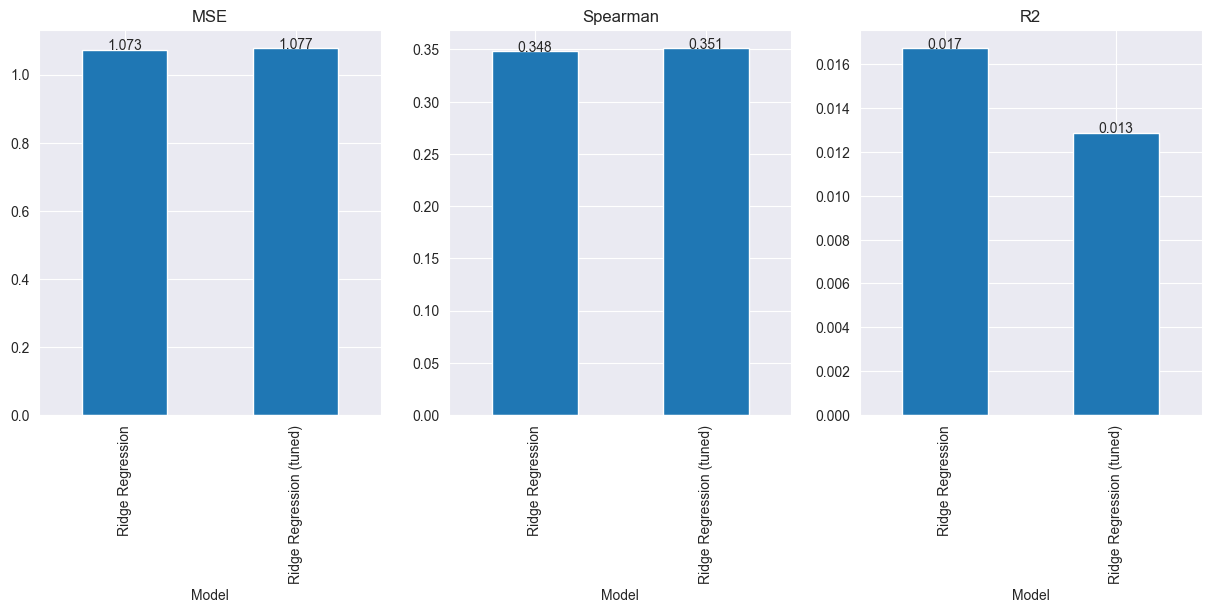

In [601]:
compare = results[results['Model'].isin(['Ridge Regression', 'Ridge Regression (tuned)'])]

# plot each metric seperately with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
compare.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
compare.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
compare.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)

# add values to the plot
for i, v in enumerate(compare['MSE']):
    axs[0].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['Spearman']):
    axs[1].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['R2']):
    axs[2].text(i, v, str(round(v, 3)), ha='center')

plt.show()

Let's save this model for further use.

In [602]:
tuned_ridge_regression = grid.best_estimator_

We can see that the tuned ridge regression model performs a little bit better than the original model. we have a higher Spearman, but a lower R2. The MSE is almost the same. Let's do the next model.


# KNN Regression

Now we will tune the hyperparameters of the KNN regression model. Using the same code as before, we will tune the hyperparameters of the KNN regression model.


In [603]:
# parameters for KNN
def spearman_score(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

param_grid = {
    #'n_neighbors': np.arange(1, 100),
    #'weights': ['uniform', 'distance'],
    #'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    #'leaf_size': np.arange(1, 100),
    'p': [1, 2],
    'leaf_size': [30, 40, 50],
    #'n_neighbors': [5, 10, 72],
}
# Create a GridSearchCV object
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(spearman_score),
    n_jobs=-1,
    return_train_score=True
)

# Fit the GridSearchCV object to the data
grid.fit(data_x_train, data_y_train['TARGET']);

So here are the best parameters for the KNN regression model.

In [604]:
print("Previous parameters :")
print(knn.get_params())
print("New parameters :")
print(grid.best_estimator_.get_params())
print("Best parameters :")
print(grid.best_params_);

Previous parameters :
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
New parameters :
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best parameters :
{'leaf_size': 30, 'p': 1}


In [605]:
predictions_tuned_knn = grid.best_estimator_.predict(data_x_test)
results = evaluateModel("KNN Regression (tuned)", predictions_tuned_knn, results)

Let's plot the predictions, and compare them to the predictions of the KNN regression model.

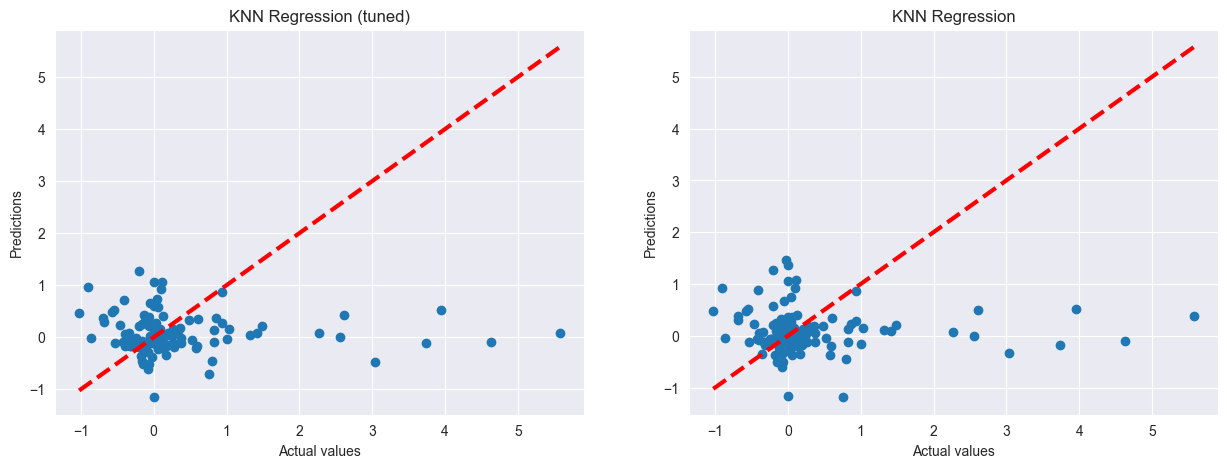

In [606]:
# create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the predictions to the actual values on the new model
axs[0].scatter(data_y_test['TARGET'], predictions_tuned_knn)
axs[0].plot([data_y_test['TARGET'].min(), data_y_test['TARGET'].max()], [data_y_test['TARGET'].min(), data_y_test['TARGET'].max()], 'r--', lw=3)
axs[0].set_title('KNN Regression (tuned)')
axs[0].set_xlabel('Actual values')
axs[0].set_ylabel('Predictions')

# Plot the predictions to the actual values on the old model
axs[1].scatter(data_y_test['TARGET'], knn_predictions)
axs[1].plot([data_y_test['TARGET'].min(), data_y_test['TARGET'].max()], [data_y_test['TARGET'].min(), data_y_test['TARGET'].max()], 'r--', lw=3);
axs[1].set_title('KNN Regression')
axs[1].set_xlabel('Actual values')
axs[1].set_ylabel('Predictions');

Now we can plot the results of the coefficients again, and compare the results of the tuned KNN regression model with the results of the KNN regression model.

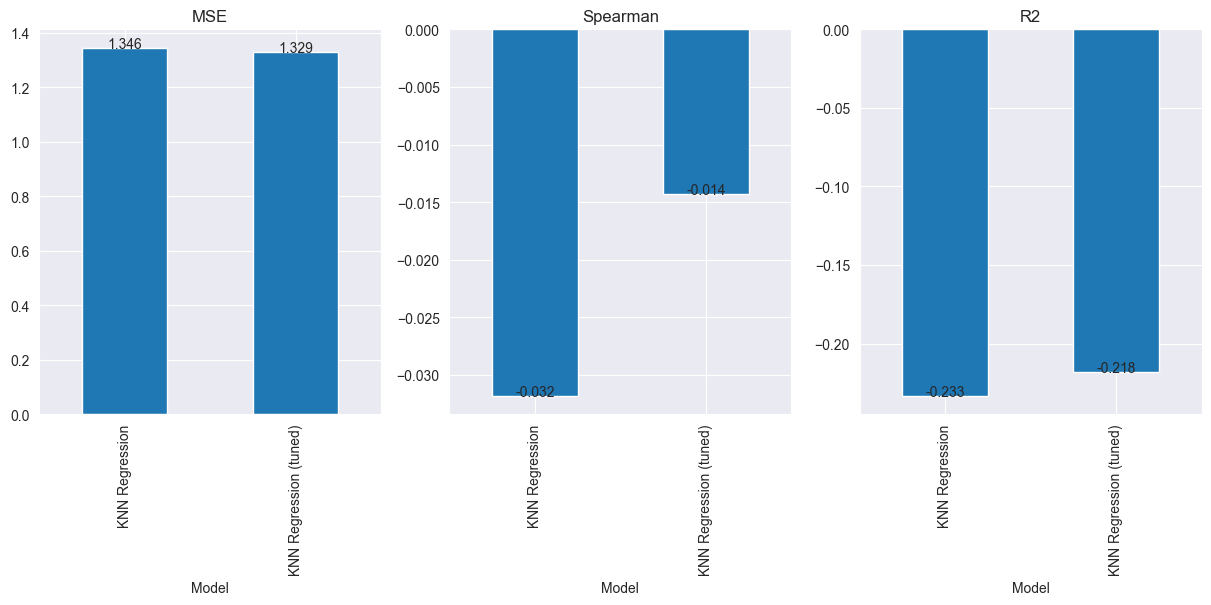

In [607]:
compare = results[results['Model'].isin(['KNN Regression', 'KNN Regression (tuned)'])]

# plot each metric seperately with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
compare.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
compare.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
compare.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)

# add values to the plot
for i, v in enumerate(compare['MSE']):
    axs[0].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['Spearman']):
    axs[1].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['R2']):
    axs[2].text(i, v, str(round(v, 3)), ha='center')

plt.show()

# do the same for the training data
compare = results[results['Model'].isin(['KNN Regression', 'KNN Regression (tuned)'])]

We can see that the tuned KNN regression model performs a little bit better than the original model. we have a higher Spearman, but a lower R2. The MSE is almost the same. In order to have a higher spearman. we only modify the p parameter. Modifying the k-neighbors parameter does not improve the r2 coeffecient. Depending on the model, changing a parameter can affect one or more metric differently. We will study this deeper in the next section. For now, let's do the next model.

# Descision Tree Regression

Now we will tune the hyperparameters of the decision tree regression model. Using the same code as before, we will tune the hyperparameters of the decision tree regression model.

In [608]:
# Create the parameter grid
param_grid = {
    'criterion' : ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    'max_depth': np.arange(1, 20),
    #'min_samples_leaf': np.arange(1, 100),
    #'max_leaf_nodes': np.arange(2, 100),
    #'min_impurity_decrease': np.arange(0.0, 1.0),
    #'min_impurity_split': np.arange(0.0, 1.0),
    #'ccp_alpha': np.arange(0.0, 1.0),
    #'random_state': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'presort': [True, False],
    #'class_weight': [None, 'balanced'],
    #'ccp_alpha': np.arange(0.0, 1.0),
    #'max_samples': np.arange(0.0, 1.0)
}

# Create a GridSearchCV object
grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(spearman_score),
    n_jobs=-1,
    return_train_score=True
);

# Fit the GridSearchCV object to the data
grid.fit(data_x_train, data_y_train['TARGET']);

/Users/paulzamanian/PycharmProjects/TradingTest/ok/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/paulzamanian/PycharmProjects/TradingTest/ok/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/paulzamanian/PycharmProjects/TradingTest/ok/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/paulzamanian/PycharmProjects/TradingTest/ok/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(st

Now that the model's best parameters are found. Let's compare them to the original model:

In [609]:
print("Previous parameters :")
print(dt.get_params())
print("New parameters :")
print(grid.best_estimator_.get_params())
print("Best parameters :")
print(grid.best_params_)


Previous parameters :
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
New parameters :
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Best parameters :
{'criterion': 'squared_error', 'max_depth': 4}


Alright ! As we can see these are the new parameters. Now let's compare the performances of this tuned model. First we create new predictions:

In [610]:
p = grid.best_estimator_.predict(data_x_test)
results = evaluateModel("Decision Tree Regression (tuned)", p, results)

Now we can plot the metrics.

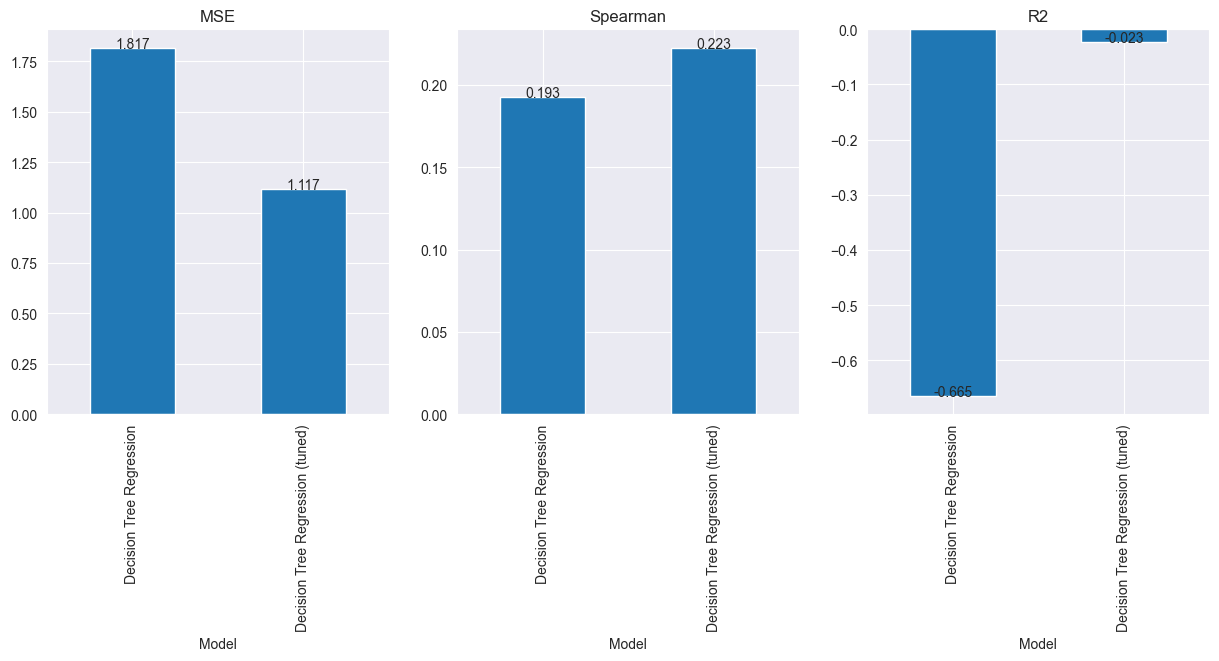

In [611]:
compare = results[results['Model'].isin(['Decision Tree Regression', 'Decision Tree Regression (tuned)'])]

# plot each metric seperately with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
compare.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
compare.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
compare.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)

# add values to the plot
for i, v in enumerate(compare['MSE']):
    axs[0].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['Spearman']):
    axs[1].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['R2']):
    axs[2].text(i, v, str(round(v, 3)), ha='center')

plt.show()

# Random Forest Regression

Now we will tune the hyperparameters of the random forest regression model. Using the same code as before, we will tune the hyperparameters of the random forest regression model.


In [612]:
# Create the parameter grid
param_grid = {
    #'criterion' : ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    #'max_depth': np.arange(1, 20),
    'min_samples_leaf': np.arange(1, 10),
    'max_leaf_nodes': np.arange(2, 20),
    #'min_impurity_decrease': np.arange(0.0, 1.0),

}
# Create a GridSearchCV object
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(spearman_score),
    n_jobs=-1,
    return_train_score=True
);

# Fit the GridSearchCV object to the data
grid.fit(data_x_train, data_y_train['TARGET']);

Now that we have fitted the grid object to the data, we can see the best parameters found by the grid search.

In [613]:
print("Previous parameters :")
print(rf.get_params())
print("New parameters :")
print(grid.best_estimator_.get_params())
print("Best parameters :")
print(grid.best_params_)

Previous parameters :
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
New parameters :
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': 4, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Best parameters :
{'max_leaf_nodes': 4, 'min_samples_leaf': 2}


Alright ! As we can see these are the new parameters. Now let's compare the performances of this tuned model. First we create new predictions:

In [614]:
p = grid.best_estimator_.predict(data_x_test)
results = evaluateModel("Random Forest Regression (tuned)", p, results)

Now we can plot the metrics.

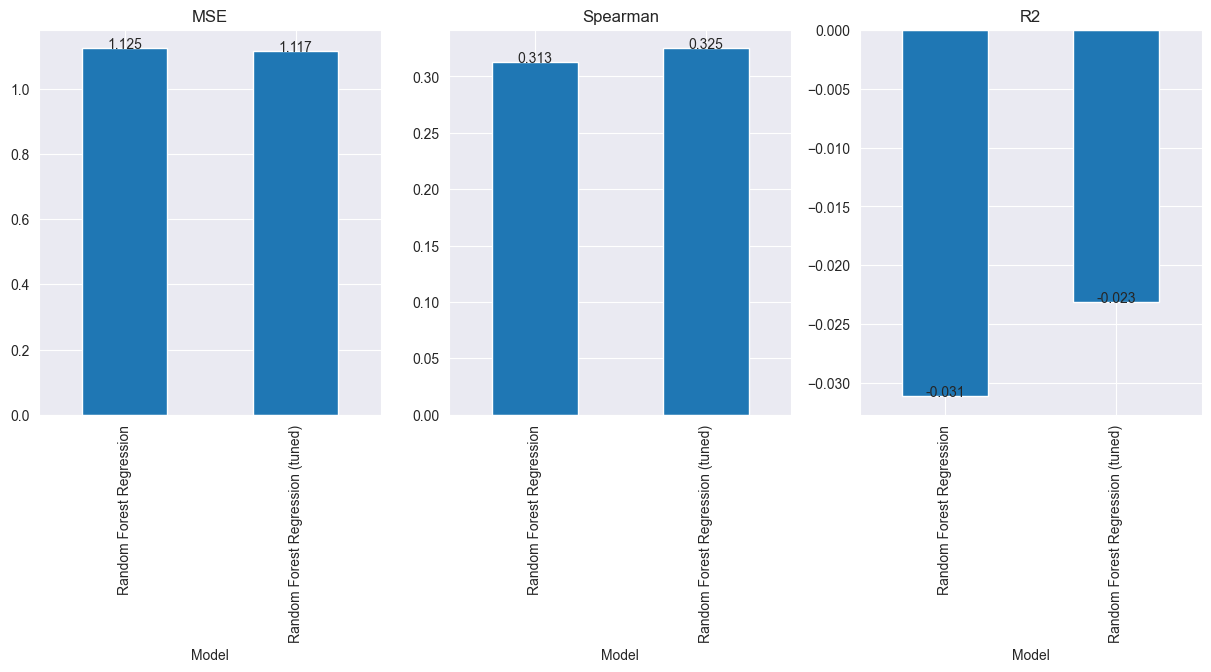

In [615]:
compare = results[results['Model'].isin(['Random Forest Regression', 'Random Forest Regression (tuned)'])]

# plot each metric seperately with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
compare.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
compare.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
compare.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)

# add values to the plot
for i, v in enumerate(compare['MSE']):
    axs[0].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['Spearman']):
    axs[1].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(compare['R2']):
    axs[2].text(i, v, str(round(v, 3)), ha='center')

plt.show()

Let's save this model for further use

In [616]:
tuned_forest_regressor = grid.best_estimator_

As we can see, the Random Forest generator once tuned is the most effective of all the models we have tested. It is therefore the one we will use to make our predictions.

#

Now let's compare all the models we have, to see which one is the most effective.

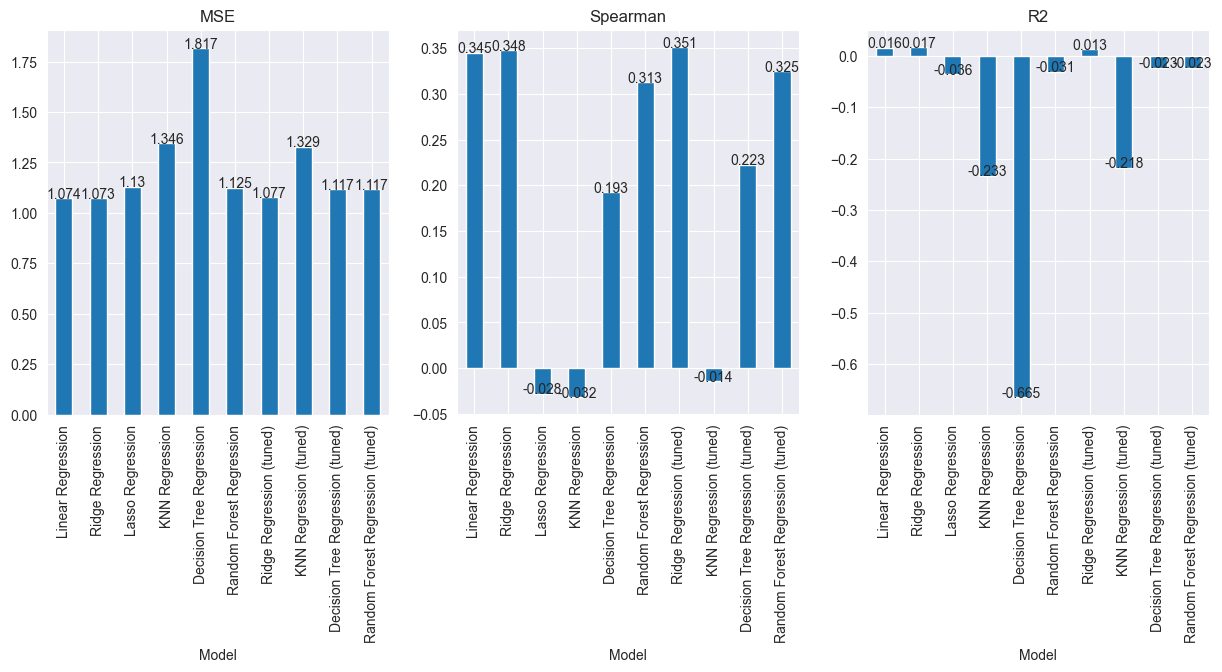

In [617]:
# plot each metric seperately with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

results.plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)
results.plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)
results.plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)

# add values to the plot
for i, v in enumerate(results['MSE']):
    axs[0].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(results['Spearman']):
    axs[1].text(i, v, str(round(v, 3)), ha='center')
for i, v in enumerate(results['R2']):
    axs[2].text(i, v, str(round(v, 3)), ha='center')

From the above plots, let's make a ranking of the models from the most effective to the least effective. In order to do so, we decide to take into account only the spearmann score, as it is the most important metric for us.



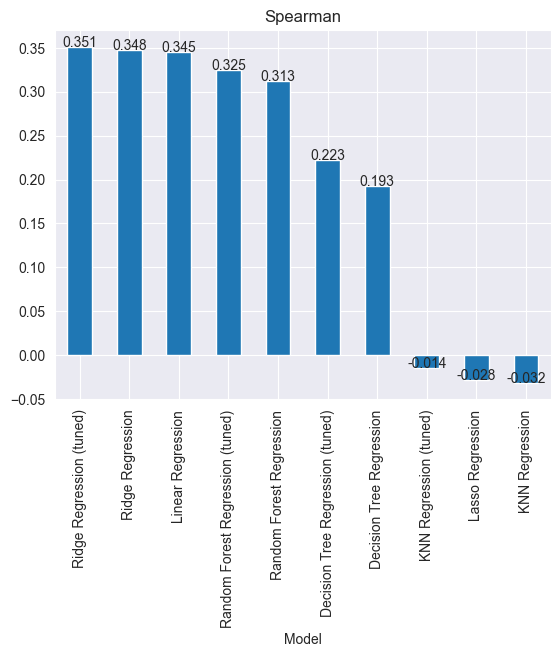

In [618]:
results.sort_values(by=['Spearman'], ascending=False, inplace=True)
# plot the spearman score of every model
results.plot(x='Model', y='Spearman', kind='bar', title='Spearman', legend=False)
# add values to the plot
for i, v in enumerate(results['Spearman']):
    plt.text(i, v, str(round(v, 3)), ha='center')
plt.show()

As we can see from the above plots, tht two most effective models are the Random Forest Regression (tuned) and the Ridge Regression (tuned). We will focus on these two models to make our predictions.

Let's isolate them from the rest to compare them better.

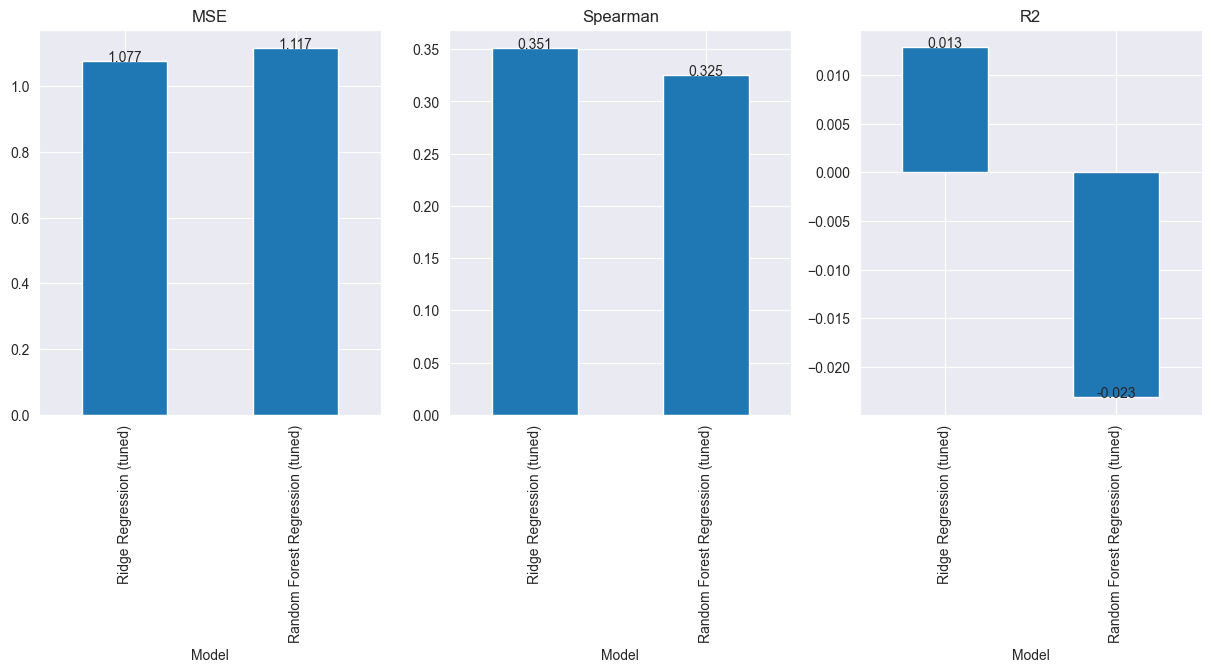

In [619]:
# plot each metric seperately with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

results[results['Model'].isin(['Random Forest Regression (tuned)', 'Ridge Regression (tuned)'])].plot(x='Model', y='MSE', kind='bar', ax=axs[0], title='MSE', legend=False)

results[results['Model'].isin(['Random Forest Regression (tuned)', 'Ridge Regression (tuned)'])].plot(x='Model', y='Spearman', kind='bar', ax=axs[1], title='Spearman', legend=False)

results[results['Model'].isin(['Random Forest Regression (tuned)', 'Ridge Regression (tuned)'])].plot(x='Model', y='R2', kind='bar', ax=axs[2], title='R2', legend=False)

# add values to the plot
for i, v in enumerate(results[results['Model'].isin(['Random Forest Regression (tuned)', 'Ridge Regression (tuned)'])]['MSE']):
    axs[0].text(i, v, str(round(v, 3)), ha='center')

for i, v in enumerate(results[results['Model'].isin(['Random Forest Regression (tuned)', 'Ridge Regression (tuned)'])]['Spearman']):
    axs[1].text(i, v, str(round(v, 3)), ha='center')

for i, v in enumerate(results[results['Model'].isin(['Random Forest Regression (tuned)', 'Ridge Regression (tuned)'])]['R2']):
    axs[2].text(i, v, str(round(v, 3)), ha='center')

# Feature importance

Now that we have isolated the two best models. Let's see which features are the most important for them. Let's start with the Ridge Regression (tuned).

## Ridge Regression (tuned) feature importance

In order to see the feature importance of the Ridge Regression (tuned), we will use the permutation importance method. This method consists in shuffling the values of a feature and measuring the impact on the model's performance. If the performance decreases, it means that the feature is important for the model. If the performance increases, it means that the feature is not important for the model.

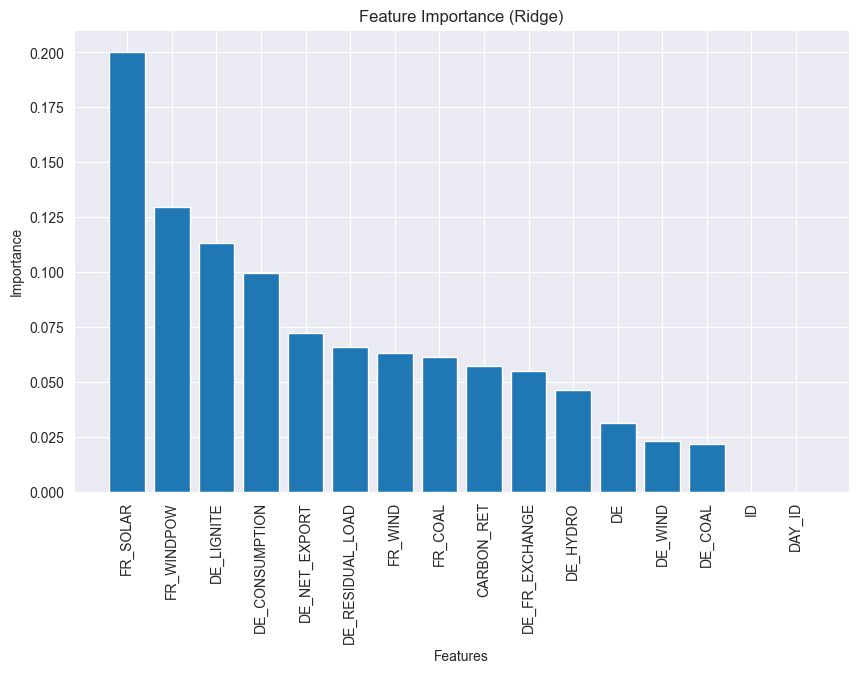

In [629]:
# Calculate feature importance
importance = np.abs(tuned_ridge_regression.coef_)
feature_names = data_x.columns

# Sort the features by their importance
sorted_indices = np.argsort(importance)[::-1]
r_sorted_features = feature_names[sorted_indices]
r_sorted_importance = importance[sorted_indices]


plt.figure(figsize=(10, 6))
plt.bar(r_sorted_features, r_sorted_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Ridge)')
plt.xticks(rotation=90)
plt.show()

Same thing for the Random Forest Regression (tuned).

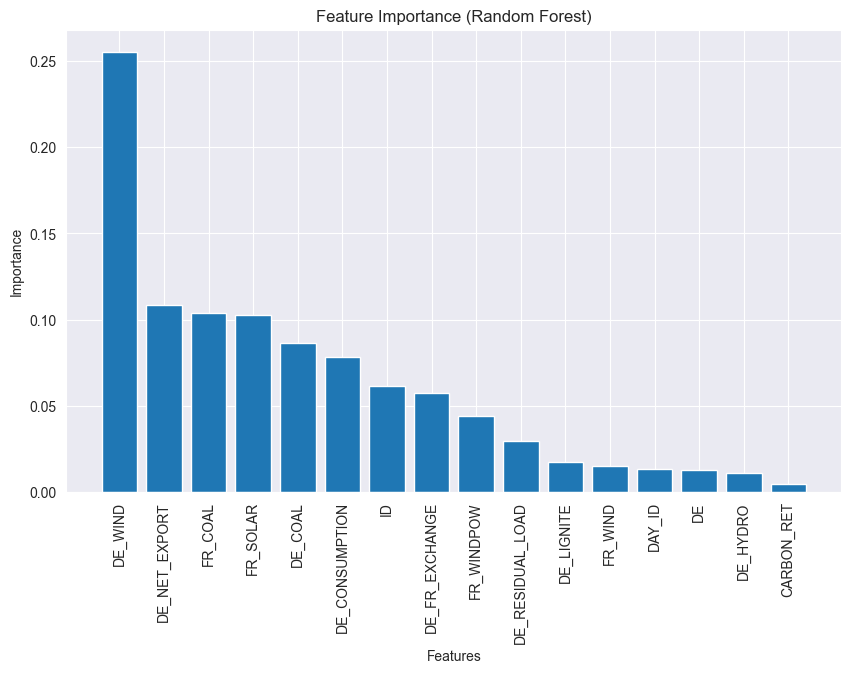

In [638]:
# Calculate feature importance
importance = tuned_forest_regressor.feature_importances_
feature_names = data_x.columns

# Sort the features by their importance
rf_sorted_indices = np.argsort(importance)[::-1]
rf_sorted_features = feature_names[sorted_indices]
rf_sorted_importance = importance[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(rf_sorted_features, rf_sorted_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.xticks(rotation=90)
plt.show()

As we can see from the above plots. Depending on the algorithms that we use, the importance of the variables vary. Let's try to regroup both of these plots in one, to see which features are important for both models.


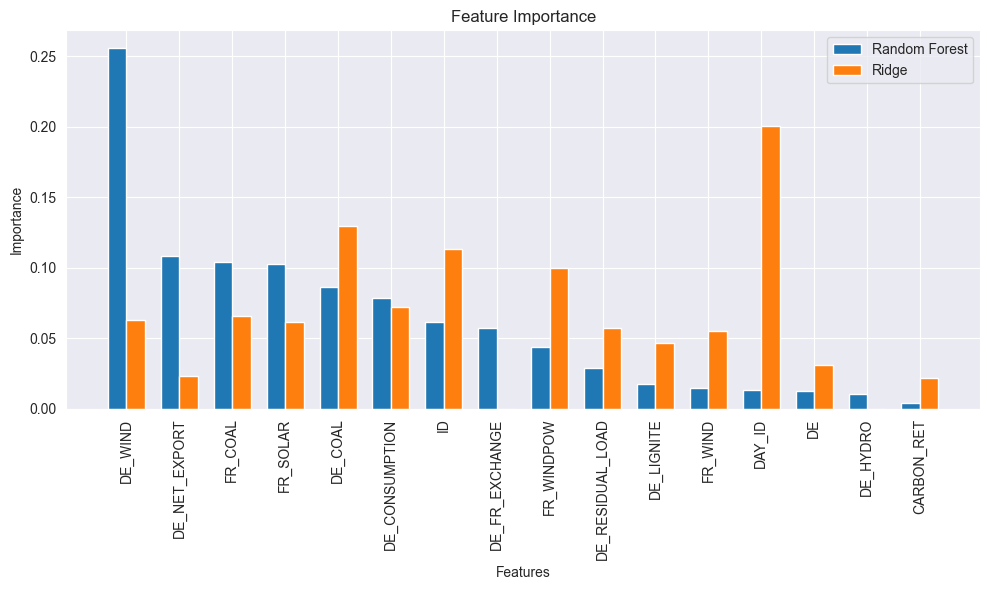

In [639]:
import matplotlib.pyplot as plt

# Calculate the x-axis positions for the bars
bar_width = 0.35
rf_positions = np.arange(len(rf_sorted_features))
r_positions = rf_positions + bar_width

# Plotting feature importance for both models
plt.figure(figsize=(10, 6))
plt.bar(rf_positions, rf_sorted_importance, width=bar_width, label='Random Forest')
plt.bar(r_positions, r_sorted_importance[np.argsort(rf_sorted_indices)], width=bar_width, label='Ridge')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rf_positions + bar_width/2, rf_sorted_features, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


# Conclusion

As we can see from the above plot, the most important features for both models are not the same. We have learnt how to clean the data. To do so we :
- normalized the data
- removed the outliers
- removed the features that were not important for the models
- removed the features that were correlated to each other
- removed the features that were not correlated to the target variable

We have also learnt how to tune the hyperparameters of the models in order to improve their performance. We have learnt how to evaluate the performance of the models using different metrics. Indeed, it was interesting to see how different metrics are used to measure different uses.

A good example is the MSE and the Spearman score. The MSE is used to measure the distance between the predicted values and the actual values. The Spearman score is used to measure the correlation between the predicted values and the actual values. So if we want to measure the distance between the predicted values and the actual values, we will use the MSE. If we want to measure the correlation between the predicted values and the actual values, we will use the Spearman score. So depending on the context, we could want a higher Spearman score for a higher MSE. But in another context, it could be more accurate to want a lower MSE, even if that means having a lower Spearman score.

We have also learnt how to compare the performance of different models using different metrics. We have learnt how to use the permutation importance method to see which features are important for the models.

We can now use the best model to make our prediction for data that we don't have the target variable for. We will use the Random Forest Regression (tuned) to make our predictions.